In [487]:
import pandas as pd

%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#importing libraries and printing wdir
import os
import pathlib as pth
import matplotlib.pyplot as plt
#from matplotlib import pyplot as plt, patches
import numpy as np
import importlib
import ipywidgets as ipw
import scipy.signal as si
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import dblquad
from scipy.optimize import differential_evolution
from scipy import interpolate
import time
from datetime import datetime

from scipy.integrate import solve_ivp
from matplotlib.colors import LogNorm
#from numba import get_num_threads,set_num_threads,config,threading_layer
from numba import jit, config, set_num_threads, get_num_threads,threading_layer


print("Current Working Directory:", os.getcwd())
print("Files in Directory:", os.listdir())  # List all files and folders


# Load the XLS file
file_path = "g3c_input.xlsx"  # Update with your actual file path
df = pd.read_excel(file_path, engine="openpyxl",skiprows=1)  # Specify engine for old .xls format

# Display the first few rows
print(df.head())

# Accessing columns
for column in df.columns:
    print(f"Column: {column}")
    print(df[column].head())  # Print first few values in each column

import bimet_morelife_gen3c
importlib.reload(bimet_morelife_gen3c)

nm=1e-9

#plot basic quantites #reference FCstate fro outside
def f_plot(sol0,fname="defname.png"):
    
    res_all=sol0.y
    res_Pt=sol0.y[0,:]
    res_thet=sol0.y[1,:]
    res_Cu=sol0.y[2,:]
    
    res_om=sol0.y[2:,:]
    res_times=sol0.t
    
    res_volt=np.copy(res_times)
    for i,j in enumerate(res_times):
        res_volt[i]=FCstate[2](j)
    
    fig, axes = plt.subplots(1,2,figsize=(18, 8))
    p4,=axes[0].plot(res_times,res_thet,color=color4, label="oxide coverage")
    p1,=axes[0].plot(res_times,res_volt,color=color1, label="voltage")
    
    axes[0].grid(True)
    axes2=axes[0].twinx()
    
    p2,=axes2.plot(res_times,res_Pt,color=color2, label="cPt2+[mol/l]")
    p3,=axes2.plot(res_times,res_Cu,color=color3, label="cCu2+[mol/l]")
    axes2.set_yscale('log')
    
    lns = [p1,p2,p3,p4]
    axes[0].legend(handles=lns, loc='best')
    axes[0].set_title("3 cycles")
    
    plt.savefig(fname)
    plt.show()


def f_norm_max(vek):
    Max=max(vek)
    return vek/Max

#translate to atomic ratio
def mass_to_atomic_ratio(mass_ratio_pt_to_cu):
    # Atomic masses of Pt and Cu
    atomic_mass_pt = 195.08  # g/mol
    atomic_mass_cu = 63.55   # g/mol

    # Convert mass ratio to atomic ratio
    atomic_ratio = mass_ratio_pt_to_cu * (atomic_mass_cu / atomic_mass_pt)
    
    return atomic_ratio

#return r vec from vec_l and vec_c
def f_vecr(vec_l,vec_c):    
    dc2 = (vec_c[1] - vec_c[0]) * 0.5
    dr2 = dc2
    vec_r= np.arange(dr2,vec_l[-1]+vec_c[-1],2*dr2)
    return vec_r


#return vector borders from vector mids.
#assuem equidist
def f_mids2bins(vec_mids):
    dr2=vec_mids[2]-vec_mids[1]
    vec_bins=np.zeros(len(vec_mids)+1)
    for i in range(len(vec_mids)):
        vec_bins[i+1]=dr2*i 
    return vec_bins

#fix a distribution by using miniumm values instead of 
def f_fix_dist(datain):
    data=np.copy(datain)
    factor=1e-2
    dmax=max(data)
    dmin=min(data[data != 0])
    
    for i,d in enumerate(datain):
        if d<dmin*factor:
            data[i]=dmin*factor

    return data
    
#create a smoothing contraint in order to fit data.
#check 3 neghbours if derivative changes sign, and not maximum provide penaltzy
def f_penal(vec):
    #loop trough 
    penals=0
    max_index = np.argmax(vec) #aha find th eabsolute maimum!
    for i,val in enumerate(vec[2:]):
        if i-1 != max_index:
            rez=np.diff([vec[i-2],vec[i-1],vec[i]])/np.min([vec[i-2],vec[i-1],vec[i]])
            if np.sign(rez[0]) != np.sign(rez[1]):
                penal = np.sum(np.abs(rez))
                #print(str(i)+" "+str(penal))
                penals +=penal
    return penals


colors=["r","g","b"]
color1="r"
color2="g"
color3="b"
color4="c"

Current Working Directory: /home/matej/work/proj/morelife/bimet_fit
Files in Directory: ['bimet_morelife_gen3c.py', '.git', 'Untitled.ipynb', 'data_HD_cycle.xlsx', '.ipynb_checkpoints', 'g3c_input.xlsx', 'work', '__pycache__', 'importg3c.ipynb', 'defname.png', 'data_HD_cycle.ods', 'PSD Analysis (JJ-0218).xlsx']
        GDL       MEM       MID     GDL.1     MEM.1     MID.1
0  4.750779  4.984424  4.517134  4.361371  4.984424  3.582555
1  4.049844  4.672897  2.803738  6.464174  5.373832  3.738318
2  3.971963  3.348910  3.971963  4.750779  4.906542  4.595016
3  4.205607  3.037383  4.127726  3.348910  3.971963  3.660436
4  4.361371  3.115265  3.348910  4.127726  4.672897  3.816199
Column: GDL
0    4.750779
1    4.049844
2    3.971963
3    4.205607
4    4.361371
Name: GDL, dtype: float64
Column: MEM
0    4.984424
1    4.672897
2    3.348910
3    3.037383
4    3.115265
Name: MEM, dtype: float64
Column: MID
0    4.517134
1    2.803738
2    3.971963
3    4.127726
4    3.348910
Name: MID, dtype:

In [488]:

file_path = "g3c_input.xlsx"  # Update with your actual file path
df = pd.read_excel(file_path, engine="openpyxl",skiprows=1)  # Specify engine for old .xls format
data_array = df.to_numpy()
print(np.shape(data_array))


(4241, 6)


[1.250e-10 3.750e-10 6.250e-10 8.750e-10 1.125e-09 1.375e-09 1.625e-09
 1.875e-09 2.125e-09 2.375e-09 2.625e-09 2.875e-09 3.125e-09 3.375e-09
 3.625e-09 3.875e-09 4.125e-09 4.375e-09 4.625e-09 4.875e-09 5.125e-09
 5.375e-09 5.625e-09 5.875e-09 6.125e-09 6.375e-09 6.625e-09 6.875e-09
 7.125e-09 7.375e-09 7.625e-09]
[1.250e-10 3.750e-10 6.250e-10 8.750e-10 1.125e-09 1.375e-09 1.625e-09
 1.875e-09 2.125e-09 2.375e-09 2.625e-09]
[1.2500e-10 3.7500e-10 6.2500e-10 8.7500e-10 1.1250e-09 1.3750e-09
 1.6250e-09 1.8750e-09 2.1250e-09 2.3750e-09 2.6250e-09 2.8750e-09
 3.1250e-09 3.3750e-09 3.6250e-09 3.8750e-09 4.1250e-09 4.3750e-09
 4.6250e-09 4.8750e-09 5.1250e-09 5.3750e-09 5.6250e-09 5.8750e-09
 6.1250e-09 6.3750e-09 6.6250e-09 6.8750e-09 7.1250e-09 7.3750e-09
 7.6250e-09 7.8750e-09 8.1250e-09 8.3750e-09 8.6250e-09 8.8750e-09
 9.1250e-09 9.3750e-09 9.6250e-09 9.8750e-09 1.0125e-08]
31 11 41


/home/matej/miniconda3/envs/bimetal-numba/lib/python3.8/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Text(0, 0.5, 'Frequency')

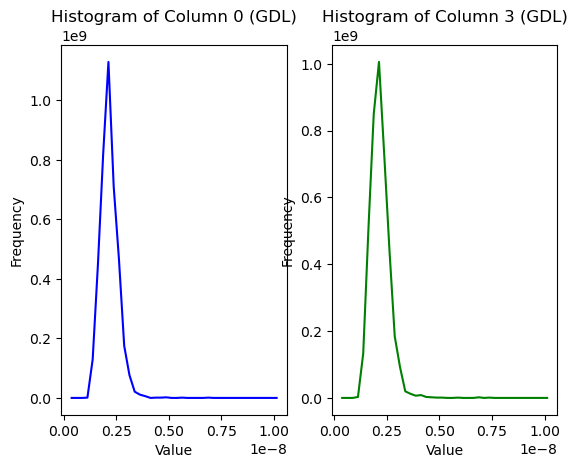

In [489]:
#problem: we have r data, dont have r bins 
#solution: select proper l, select proper c to discretize data.
#create r -> rebin. 
lmin=0.25
lmax=3
cmin=0.25
cmax=8


vec_c,vec_l=bimet_morelife_gen3c.f_vl_vc(lmin,lmax,cmin,cmax)
print(vec_c)
print(vec_l)
vec_r=f_vecr(vec_l,vec_c)

print(vec_r)

print(str(len(vec_c))+" "+str(len(vec_l))+" "+str(len(vec_r)))

bins_r = f_mids2bins(vec_r)

hist1 = np.histogram(nm*df.iloc[:, 0].dropna().to_numpy()*0.5,bins=bins_r,density=True)
hist2 = np.histogram(nm*df.iloc[:, 1].dropna().to_numpy()*0.5,bins=bins_r,density=True)

#hist
#bins_r
nm*df.iloc[:, 0].dropna().to_numpy()*0.5

# Histogram for Column 0
plt.subplot(1, 2, 1)
plt.plot(vec_r,hist1[0],color="b")
#hist = np.histogram(nm*df.iloc[:, 0].dropna().to_numpy()*0.5,bins=bins_r,density=True)
#plt.stem(hist[1][:-1],hist[0])
#plt.xlim([0.5*nm,7*nm])
plt.title(f"Histogram of Column 0 ({df.columns[0]})")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Histogram for Column 3
plt.subplot(1, 2, 2)
plt.plot(vec_r,hist2[0],color="g")

#plt.hist(selected_columns.iloc[:, 1].dropna()*0.5, bins=25, color='green')
plt.title(f"Histogram of Column 3 ({df.columns[0]})")
plt.xlabel("Value")
plt.ylabel("Frequency")


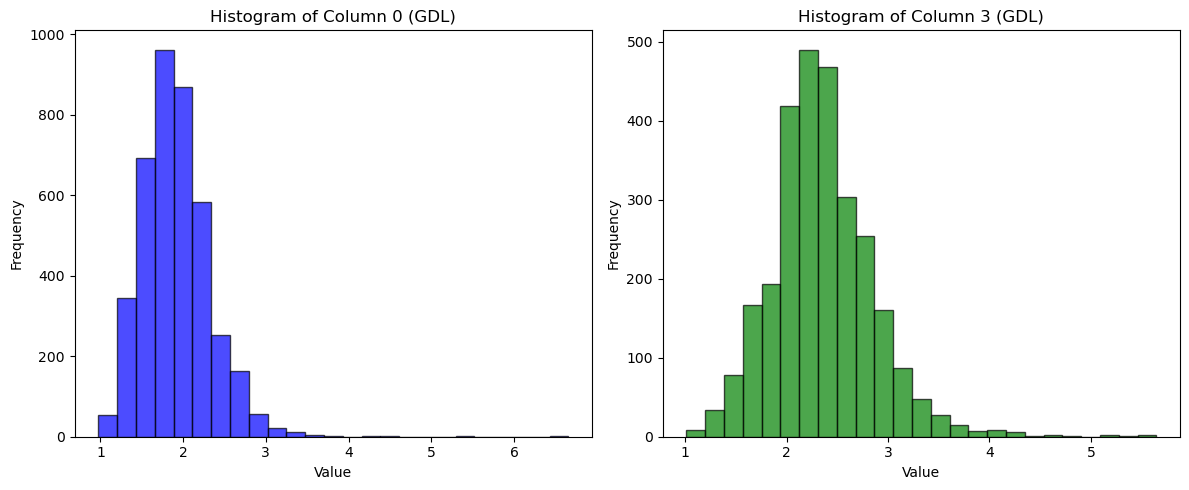

In [490]:
selected_columns = df.iloc[:, [0, 3]]  # Select first and fourth columns

# Plot histograms
plt.figure(figsize=(12, 5))

# Histogram for Column 0
plt.subplot(1, 2, 1)
plt.hist(selected_columns.iloc[:, 0].dropna()*0.5, bins=25, color='blue', edgecolor='black', alpha=0.7)
#hist = np.histogram(nm*df.iloc[:, 0].dropna().to_numpy()*0.5,bins=bins_r,density=True)
#plt.stem(hist[1][:-1],hist[0])
#plt.xlim([0.5*nm,7*nm])
plt.title(f"Histogram of Column 0 ({df.columns[0]})")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Histogram for Column 3
plt.subplot(1, 2, 2)
plt.hist(selected_columns.iloc[:, 1].dropna()*0.5, bins=25, color='green', edgecolor='black', alpha=0.7)
plt.title(f"Histogram of Column 3 ({df.columns[0]})")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [491]:
#data succesfully imported
#now describe starting distribution
FCstate=bimet_morelife_gen3c.FCstate
ModPars0=np.copy(bimet_morelife_gen3c.ModPars)
vek_in=[6.420e-01,2.699e-01,2.000e-01,1.148e+00]
#n=7 starting synthetic ratio.
#end mass ratio. 28/1.8
#translate to atomic ratio
#assume there is core and shell structure
#assume some distribution in shell #uniform relatively sharp with free parameter POSITON 
#adjust core distriburtion parameters to fit the final distribution and final pt/cu ratio
#finaly normalise to pt data

#n=7 starting synthetic ratio. Fixed in librarz CHECK
#end mass ratio. 28/1.8 TODO CHECK
Pt_Cu_rat=25.8/0.8
print(f"Mass Ratio (Pt:Cu) = {Pt_Cu_rat:.4f}")

# Example: If mass ratio (Pt:Cu) is 2:1 (meaning 2g Pt for 1g Cu)
#mass_ratio = 2  # Adjust based on your input
atomic_ratio = mass_to_atomic_ratio(Pt_Cu_rat)

print(f"Atomic Ratio (Pt:Cu) = {atomic_ratio:.4f}")

#assume there is core and shell structure
#assume some distribution in shell #uniform relatively sharp with free parameter POSITON
#adjust core distriburtion parameters to fit the final distribution and final pt/cu ratio
bimet_morelife_gen3c.f_start_dist_alter(lmin=0.25,lmax=5,cmin=0.25,cmax=10,MPars=ModPars0, loc_l=0.25, scale_l=0.25, s_c=0.7, loc_c=0.4, scale_c=2)
#finaly normalise to pt data 
Pt_load=0.15 #mg/cm2

Mass Ratio (Pt:Cu) = 32.2500
Atomic Ratio (Pt:Cu) = 10.5059


23
19
41
41
10.9575407936796
10.505882202173467
23
19
41
437
440


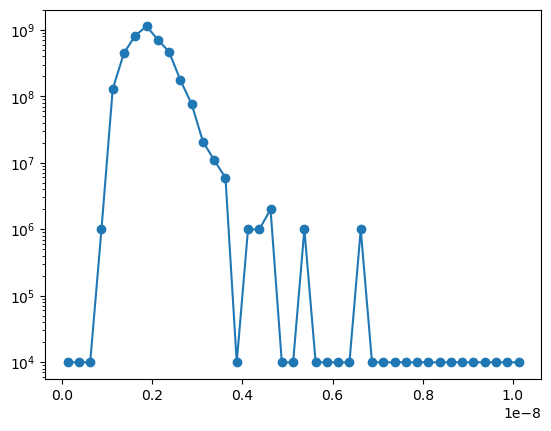

In [497]:
#plot starting dist normed to r, as well as Pt,Cu ratio. Should be more than 3. since some of cu is lost
FCstate=bimet_morelife_gen3c.FCstate
ModPars0=np.copy(bimet_morelife_gen3c.ModPars)
vek_in=[6.420e-01,2.699e-01,2.000e-01,1.148e+00]
vek_in=[ 6.575e-01 , 2.699e-01 , 1.003e-02 , 1.325e+00]
vek_in=[ 6.573e-01 , 2.698e-01 , 1.105e-02 , 1.324e+00]
dist_bins_om ,vec_c, vec_l=bimet_morelife_gen3c.f_start_dist_alter(lmin=0.25,lmax=5,cmin=0.25,cmax=6,MPars=ModPars0, loc_l=vek_in[0], scale_l=0.25, s_c=vek_in[1], loc_c=vek_in[2], scale_c=vek_in[3])
#dist_bins_om ,vec_c, vec_l=bimet_morelife_gen3c.f_start_dist_alter(lmin=0.25,lmax=5,cmin=0.25,cmax=6,MPars=ModPars, loc_l=0.25, scale_l=0.25, s_c=0.7, loc_c=0.4, scale_c=2)
pars=(ModPars0,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])

#make dr
dc2 = (vec_c[1] - vec_c[0]) * 0.5
#does it have to be that way? would it work with any dr?
dr2 = dc2
#dr vector
vec_r= np.arange(dr2,vec_l[-1]+vec_c[-1],2*dr2)

print(len(vec_c))
print(len(vec_l))
print(len(vec_r))

nSt = 3
#number of bins
nc = len(vec_c)
nl = len(vec_l)
# total number of variables
nSys = nSt+nc*nl

### set initial distribution
#initial states
X0 = np.zeros(nSys)
# cathode
#fill the bins starting vector
X0[0]=1.0*10**-10
X0[1]=1.0*10**-2
X0[2]=1.0*10**-10
X0[3:]=dist_bins_om.flatten()

#solve a run
#sol0 = solve_ivp(f_dfdt, (ti[0],ti[-1]), X0, method='LSODA',events=stop_condition, t_eval=ti, args=pars, rtol  = tol_r, atol = tol_a)
#sol0 = solve_ivp(f_dfdt, (ti[0],ti[-1]), X0, method='LSODA',events=None, t_eval=ti, args=pars, rtol  = tol_r, atol = tol_a)

#get X from the solution
#X=sol0.y[:,-1]

#transform to r distribution
#res,vec_r=f_cl_to_rl_rc(X,nSt,vec_l,vec_c)
om=bimet_morelife_gen3c.f_X_to_dist(X0,vec_l,vec_c)
r=bimet_morelife_gen3c.f_om_to_r(om)
print(len(r))
#norm end r dist
rez_norm_r = bimet_morelife_gen3c.f_norm_dist1d(vec_r,r)

#calculate the price function
#d2_n calculated before, its a hardcoded input for all evolution calls
#price = f_sum_abs(d2_n,rez_norm_r,vec_r)

bins_r=np.insert(vec_r+vec_r[0],0,0)
hist = np.histogram(nm*df.iloc[:, 0].dropna().to_numpy()*0.5,bins=bins_r,density=True)



#plt.plot(vec_r,f_norm_max(rez_norm_r))
#plt.plot(vec_r,hist[0],marker="o")

plt.plot(vec_r,hist_fix,marker="o")

#plt.plot(vec_r,f_norm_max((vec_r**3*abs(rez_norm_r-hist[0]))),marker="o")
"""
hist = np.histogram(nm*df.iloc[:, 3].dropna().to_numpy()*0.5,bins=bins_r,density=True)
plt.plot(vec_r,rez_norm_r)
plt.plot(vec_r,hist[0],marker="o")
"""
plt.yscale('log')
#plt.ylim([1e4,2e9])

X=bimet_morelife_gen3c.f_dist_to_X(dist_bins_om)
#calc pt_cu as well give it half the weight
rez_stats = bimet_morelife_gen3c.f_stats(X,ModPars0,vec_c,vec_l)
pt_cu=rez_stats[-2]/rez_stats[-1]

print(pt_cu)
print(atomic_ratio)

print(len(vec_c))
print(len(vec_l))
print(len(vec_r))
print(len(vec_l)*len(vec_c))
print(len(X0))
#ok so far

1.118 2.4
[16]
[(1.2, 4.8)]
0.10625454367554739
3.845551687959016
0.9500640323168922
0.0005764326496429106
4.796192152925551
4.796192152925551
THIS IS FINE!
31
11
41
341
440
cyc
skip
(1,)
(10,)
(440,)
round_max 2
0
mode 0: calculating 2 cycles


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


ValueError: cannot assign slice from input of different size

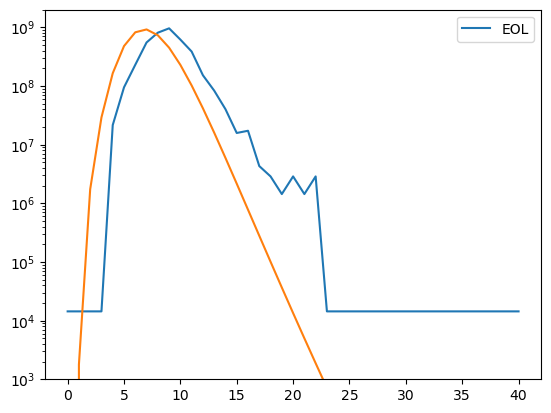

In [501]:
#vars=[0,1,3,7,8,9,10,11]
vars=[16]
#vars=[14,16,22]
#vars=[14,16]
initial_vars=[]
bounds = []
vars_0=[]

#construct boundaries to check
#if variable is around unity var by half if not var by order
for i in vars:
    #make first guess
    vars_0.append(ModPars[i])
    #construct bounds
    if 0.5 < ModPars[i] <=1.5:
        bounds.append((ModPars[i]*0.8,ModPars[i]*1.2))
        initial_vars.append(ModPars[i])
    elif 1.5 < ModPars[i] <3:
        bounds.append((ModPars[i]*0.5,ModPars[i]*2))
        initial_vars.append(ModPars[i])
    elif 0.01 < ModPars[i] <0.5:
        bounds.append((ModPars[i]*0.5,ModPars[i]*2))
        initial_vars.append(ModPars[i])
    else:
        bounds.append((ModPars[i]*0.5,ModPars[i]*2))
        initial_vars.append(ModPars[i])

for i,j in enumerate(vars):
    print( str(vek_in[i]) + " " + str(ModPars0[j]) )

print(vars)
print(bounds)


pars0=(ModPars0,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])

def f_test_cycle_skip(MC=3000,round_factor=0.8, round_max_f=0.2,pars=pars0):
    
    ModPars=pars[0]
    
    tStart = time.time()

    #start cycles
    s_cycs=2
    #all positive bins never happens in this cycling
    d_cyc=2
    #finish steps
    finish_steps=3
    
    t0=0
    rez_stat_4=bimet_morelife_gen3c.f_stats(X0,ModPars,vec_c,vec_l)
    rez_stat_4=np.array(rez_stat_4)
    rez_t_4=[t0]
    Xin=X0
    rez_X_4=np.array(X0)
    rez_n_4=[0]
    
    print(np.shape(rez_n_4))
    print(np.shape(rez_stat_4))
    print(np.shape(rez_X_4))

    round_max = int(round_max_f*MC)
    print("round_max "+str(round_max))
    
    current_date = datetime.now().strftime('%Y-%m-%d')
    base_filename = f"data_"+str(round_max)+f"_sim_{current_date}.txt"
    filename =  bimet_morelife_gen3c.f_create_unique_filename(base_filename)
    #f_append_to_file(filename,str(0) + " " + str(X0) )
    
    i=0
    while i<MC:
        #print(np.shape(rez_n_4))
        #print(np.shape(rez_stat_4))
        #print(np.shape(rez_X_4))
        print(i)
        #initialise maybe calc a few cycles
        #this remains the same as previous versions
        if i<s_cycs:
            print("mode 0: calculating "+str(s_cycs)+" cycles")
            #sol=f_run_cyc(Xin,0,s_cycs)
            #sol=bimet_morelife_gen3c.f_run_cyc(Xin,Am/(rateMax),0,s_cycs)
            sol=bimet_morelife_gen3c.f_run_cyc(Xin,Am/(rateMax),0,s_cycs,pars,tol_r,tol_a)

            Xin=sol.y[:,-1]
            t0=sol.t[-1]
    
            trez=Xin
            trez_stat=f_stats(trez,ModPars,vec_c,vec_l)
            rez_stat_4=np.vstack((rez_stat_4,trez_stat))
            #rez_t_2.append(t0)
    
            rez_X_4=np.vstack((rez_X_4,Xin))
            
            i=i+s_cycs
            rez_n_4.append(i)
            
        else:
            print("mode 1: calculating "+str(1)+" cycle")
            #calc one cycle to get dX
            X01=Xin
            #run a cycle and calculate dX
            #sol=bimet_morelife_gen3c.f_run_cyc(Xin,Am/(rateMax),0,1)
            tStart = time.time()
            sol=bimet_morelife_gen3c.f_run_cyc(Xin,Am/(rateMax),0,1,pars,tol_r,tol_a)
            tEnd = time.time()
            print("Dt= "+str(tEnd-tStart))

            Xin=sol.y[:,-1]
    
            if np.any(Xin[4:])<=0:
                print("encountered negative value")
                break
            
            dX=bimet_morelife_gen3c.f_calc_delta(X01,Xin,ModPars,vec_c,vec_l)
            
            i=i+1
            #this may need to be changed in ver 2 in order to fix indices
            Xin=sol.y[:,-1]
            #we increment this anyways
    
            #check how much iteration we can afford. 
            #loop trough all the ratios in diferentials.
            #increment dX
            #print(min(abs(Xin)))
            #print(min(abs(dX)))
            Xratios=Xin/dX
            
            #check wat is the smallest negative value and also report index.
            max_ratio= highest_negative = np.max(Xratios[Xratios < 0]) if np.any(Xratios < 0) else None
            
            print("max_ratio= "+str(max_ratio))
            #treshold = 2.
    
            #all positive for some reason
            #not very likely
            if max_ratio == None:
                print("\tIF = all positive: keep going")
                #skip d_cycs
                Xin=Xin+dX*d_cyc
                i=i+d_cyc
    
            #we can actually skip a few steps
            elif abs(max_ratio) > 2:
                #rounded_down = max_ratio
                #print("rounded down "+str(rounded_down))
                #rounded_down = round_factor
                #print("rounded down "+str(rounded_down))
                #rounded_down = max_ratio*round_factor
                #print("rounded down "+str(rounded_down))
                #rounded_down = abs(max_ratio*round_factor)
                #print("rounded down "+str(rounded_down))
                rounded_down = int(abs(max_ratio*round_factor))
                #print("rounded down "+str(rounded_down))
                rounded_down = min( rounded_down ,round_max)
                #print("rounded down "+str(rounded_down))
                #rounded_down=max(rounded_down,1)
                print("rounded down "+str(rounded_down))
                #check if we can finish get close and do a few loops
                #do some loops
                #finish up
                #break
                if i+rounded_down >= MC:
                    print("finishing")
                    #first do some steps then finish up
                    if MC-i > finish_steps:
                        d_cyc=MC-i-finish_steps
                        Xin=Xin+dX*d_cyc  
                        sol=bimet_morelife_gen3c.f_run_cyc(Xin,Am/(rateMax),0,finish_steps,pars,tol_r,tol_a) 
                        i=MC
                    #just finish up
                    else:
                        sol=bimet_morelife_gen3c.f_run_cyc(Xin,Am/(rateMax),0,finish_steps,pars,tol_r,tol_a) 
                        i=MC
                    break
                
                print("\tIF > 2: cycle "+ str(rounded_down))
                Xin=Xin+dX*rounded_down
                i=i+rounded_down
    
            #we cant propagate
            else:
                print("\tIF < 2: repeate")
                #we have only calculated 
                pass
    
            #record vector and stats and index values at the end.
            #f_append_to_file(filename,str(i) + " " + str(Xin) )
            
        rez_X_4=np.vstack((rez_X_4,Xin))
        trez_stat=f_stats(Xin,ModPars,vec_c,vec_l)
        rez_stat_4=np.vstack((rez_stat_4,trez_stat))
        rez_n_4.append(i)

    #w_string=str(i) + " " + np.array2string(Xin, threshold=np.inf, precision=8, separator=", ").replace("\n", "")
    #bimet_morelife_gen3c.f_append_to_file(filename,w_string)
    #tEnd = time.time()
    #bimet_morelife_gen3c.f_append_to_file(filename,str(tEnd-tStart))

    print("finish:" + str(i))
    #return rez_X_4,rez_stat_4,rez_n_4
    return sol,rez_X_4,rez_n_4,rez_stat_4

def f_price_EOL(vek_in):
    print("inf_eol")
    print(vek_in)
    #insert calculated om
    hist_EOL = np.histogram(nm*df.iloc[:, ind+3].dropna().to_numpy()*0.5,bins=bins_r,density=True)
    hist_fix_EOL=bimet_morelife_gen3c.f_norm_dist1d(vec_r,f_fix_dist(hist_EOL[0]))

    #fill the modpars
    #ModPars0=np.copy(bimet_morelife_gen3c.ModPars)
    ModPars0=np.copy(ModPars)  
    for i,j in enumerate(vars):
        ModPars0[j]=vek_in[i]
    print(ModPars0)
    #print(ModPars0[14])
    #ModPars0[14]=1.1
    #ModPars[16]=3.
    #ModPars0[22]=0.001*10**9
    
    #ModPars[9]=1.0*10**4    # nuForPt   Dissolution atmpto frequency [1/s]
    #ModPars[10]=8*10**5  
    #ModPars0[9]=5.0*10**3    # nuForPt   Dissolution atmpto frequency [1/s]
    #ModPars0[10]=5.*10**7

    pars0=(ModPars0,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])
    sol,rez_X_4,rez_n_4,rez_stat_4 = f_test_cycle_skip(MC=10,round_factor=0.8, round_max_f=0.2,pars=pars0)
    om=f_X_to_dist(sol.y[:,-1],vec_c,vec_l)
    
    r=bimet_morelife_gen3c.f_om_to_r(om)
    rez_norm_r = bimet_morelife_gen3c.f_norm_dist1d(vec_r,r)

    #hist = np.histogram(nm*df.iloc[:, 0].dropna().to_numpy()*0.5,bins=bins_r,density=True)
    priceN = bimet_morelife_gen3c.f_sum_abs( hist_EOL,rez_norm_r,vec_r)
    priceS = bimet_morelife_gen3c.f_sum_abs( hist_EOL*vec_r*vec_r/(nm**2),rez_norm_r*vec_r*vec_r/(nm*2),vec_r)
    priceV = bimet_morelife_gen3c.f_sum_abs( hist_EOL*vec_r*vec_r*vec_r/(nm**3),rez_norm_r*vec_r*vec_r*vec_r/(nm**3),vec_r)
    
    print(priceN)
    print(priceS)
    print(priceV)

    X=bimet_morelife_gen3c.f_dist_to_X(dist_bins_om)
    #calc pt_cu as well give it half the weight
    rez_stats = bimet_morelife_gen3c.f_stats(X,ModPars0,vec_c,vec_l)
    pt_cu=rez_stats[-2]/rez_stats[-1]
    #print(pt_cu)
    #print(rez_stats[-1])

    pt_price=abs(pt_cu-atomic_ratio)
    print(pt_price)

    #alter prices
    price=priceS+priceV
    price=priceN
    print(price)
    
    """
    fig=plt.figure(figsize=(14, 8))
    ax11 = fig.add_subplot(1,1,1)
    ax=ax11
    im = ax.imshow(dist_bins_om,extent =[vec_c[0], vec_c[-1], vec_l[0], vec_l[-1]], interpolation ='none',origin='lower')
    fig.colorbar(im, ax=ax)
    ax.set_title("doist BOE")
    """

    plt.plot(rez_norm_r,label="sim-EOL")
    plt.plot(hist_fix_EOL,label="ex-EOL")

    
    return price

vek_0=[ 6.575e-01 , 2.699e-01 , 1.003e-02 , 1.325e+00]
vek_in=vek_0
print(f_price(vek_in))

def f_callback(xk, convergence):
    price=f_price_direct(xk)
    print(f"Current solution: {xk}, price: {price}, Convergence: {convergence}")

ind=0

hist_EOL = np.histogram(nm*df.iloc[:, ind+3].dropna().to_numpy()*0.5,bins=bins_r,density=True)
hist_fix_EOL=f_fix_dist(hist_EOL[0])

hist_BOL = np.histogram(nm*df.iloc[:, ind].dropna().to_numpy()*0.5,bins=bins_r,density=True)
hist_fix_BOL=f_fix_dist(hist_BOL[0])

dist_bins_om ,vec_c, vec_l=bimet_morelife_gen3c.f_start_dist_alter(lmin=0.25,lmax=3,cmin=0.25,cmax=8,MPars=ModPars0, loc_l=vek_in[0], scale_l=0.25*0.5, s_c=vek_in[1], loc_c=vek_in[2], scale_c=vek_in[3])
r_BOL=bimet_morelife_gen3c.f_om_to_r(dist_bins_om)
rez_norm_r_BOL = bimet_morelife_gen3c.f_norm_dist1d(vec_r,r)

plt.plot(hist_fix_EOL,label="EOL")
#plt.plot(hist_fix_BOL,label="BOL")
plt.legend()
#plt.plot(hist_moved)
#plt.plot(r)
plt.plot(rez_norm_r_BOL)

#plt.plot(np.abs(rez_norm_r-hist_fix))
#plt.yscale("log")
#plt.ylim([1e3,4e9])

#dist_bins_om ,vec_c, vec_l = bimet_morelife_gen3c.f_start_dist_cin(hist_fix,lmin1=0.25,lmax1=5.,cmin1=0.25,MPars=ModPars, loc_l=0.25*3, scale_l=0.25*0.5)
#vek_in = np.append([0.25*3],hist_fix)
    
#f_price_direct(vek_in)
#plt.plot(hist[1][1:],hist[0])
plt.yscale("log")
plt.ylim([1e3,2e9])
#plt.imshow(dist_bins_om)

#print(f_penal(hist_fix))
#print(hist_fix)

print("THIS IS FINE!")
#TODO resutl distribution
#print(bins_r)
#print(len(hist_fix_EOL))
#print(len(bins_r))
print(len(vec_c))
print(len(vec_l))
print(len(vec_r))
print(len(vec_l)*len(vec_c))
print(len(X0))
vek_0=[1.118]
vek_in=vek_0


pars0=(ModPars0,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])
print("cyc")
sol=bimet_morelife_gen3c.f_run_cyc(Xin,Am/(rateMax),0,5,pars0,tol_r,tol_a)
print("skip")
sol,rez_X_4,rez_n_4,rez_stat_4 = f_test_cycle_skip(MC=10,round_factor=0.8, round_max_f=0.2,pars=pars0)
print(price)
print(f_price_EOL(vek_in))

In [471]:
#do fast optimisation dif evo price function

vek_in=[ 6.573e-01 , 2.698e-01 , 1.105e-02 , 1.324e+00]
dist_bins_om ,vec_c, vec_l=bimet_morelife_gen3c.f_start_dist_alter(lmin=0.25,lmax=3,cmin=0.25,cmax=8,MPars=ModPars0, loc_l=vek_in[0], scale_l=0.25*0.5, s_c=vek_in[1], loc_c=vek_in[2], scale_c=vek_in[3])
dc2 = (vec_c[1] - vec_c[0]) * 0.5
dr2 = dc2
vec_r= np.arange(dr2,vec_l[-1]+vec_c[-1],2*dr2)
hist = np.histogram(nm*df.iloc[:, 0].dropna().to_numpy()*0.5,bins=bins_r,density=True)

ModPars= np.copy(bimet_morelife_gen3c.ModPars)
dist_bins_om ,vec_c, vec_l = bimet_morelife_gen3c.f_start_dist_cin(hist[0],lmin1=0.25,lmax1=5.,cmin1=0.25,MPars=ModPars, loc_l=0.25, scale_l=0.25)

#alternative implementation of fiting
#start by offsetting 
def f_price_direct(vek_in):
    try:
        #make it anyway. easier to work with.
        dist_bins_om ,vec_c, vec_l = bimet_morelife_gen3c.f_start_dist_cin(vek_in[1:],lmin1=0.25,lmax1=5.,cmin1=0.25,MPars=ModPars, loc_l=vek_in[0], scale_l=0.25*0.5)
        #dist_bins_om ,vec_c, vec_l = bimet_morelife_gen3c.f_start_dist_cin(vek_in[1:],lmin1=0.25,lmax1=5.,cmin1=0.25,MPars=ModPars, loc_l=vek_in[0], scale_l=0.25*0.5)
        pars=(ModPars0,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])
    
        #print(vec_l)
        #print(vec_c)
        
        dc2 = (vec_c[1] - vec_c[0]) * 0.5
        dr2 = dc2
        vec_r= np.arange(dr2,vec_l[-1]+vec_c[-1],2*dr2)
    
        """
        print(len(vek_in[1:]))
        print(len(hist[0]))
        print(len(vec_l))
        print(len(vec_c))
        print(len(vec_r))
        """
    
        r=bimet_morelife_gen3c.f_om_to_r(dist_bins_om)
        rez_norm_r = bimet_morelife_gen3c.f_norm_dist1d(vec_r,r)
    
        bins_r=np.insert(vec_r+vec_r[0],0,0)
        #hist = np.histogram(nm*df.iloc[:, 0].dropna().to_numpy()*0.5,bins=bins_r,density=True)
        priceN = bimet_morelife_gen3c.f_sum_abs( hist[0],rez_norm_r,vec_r)
        priceS = bimet_morelife_gen3c.f_sum_abs( hist[0]*vec_r*vec_r/(nm**2),rez_norm_r*vec_r*vec_r/(nm*2),vec_r)
        priceV = bimet_morelife_gen3c.f_sum_abs( hist[0]*vec_r*vec_r*vec_r/(nm**3),rez_norm_r*vec_r*vec_r*vec_r/(nm**3),vec_r)
    
        priceDer=f_penal(vek_in[1:])
    
        #print(priceN)
        #print(priceS)
        #print(priceV)
        #print(priceDer)
    
        X=bimet_morelife_gen3c.f_dist_to_X(dist_bins_om)
        #calc pt_cu as well give it half the weight
        rez_stats = bimet_morelife_gen3c.f_stats(X,ModPars0,vec_c,vec_l)
        pt_cu=rez_stats[-2]/rez_stats[-1]
        #print(pt_cu)
        #print(rez_stats[-1])
    
        pt_price=abs(pt_cu-atomic_ratio)
        #print(pt_price)
        
        #price=priceN+priceS+priceV+pt_price+priceDer
        price=priceN+pt_price+priceDer
    
        #price=priceN+pt_price
    
        
        #print(rez_stats)
    
        #interpolate to r values
        """
        fig=plt.figure(figsize=(14, 8))
        ax11 = fig.add_subplot(1,1,1)
        ax=ax11
        im = ax.imshow(dist_bins_om,extent =[vec_c[0], vec_c[-1], vec_l[0], vec_l[-1]], interpolation ='none',origin='lower')
        fig.colorbar(im, ax=ax)
        ax.set_title("doist BOE")
        """
    
        if np.isinf(price) or np.isnan(price):
            print("nan or inf")
            return np.inf  # Penalize bad solutions
        
        return price
        
    except ValueError as e:
        print(f"Error: {e}")
        #print("ujel error")
        return np.inf  # Catch any errors  

def f_price(vek_in):
    
    dist_bins_om ,vec_c, vec_l=bimet_morelife_gen3c.f_start_dist_alter(lmin=0.25,lmax=3,cmin=0.25,cmax=8,MPars=ModPars0, loc_l=vek_in[0], scale_l=0.25*0.5, s_c=vek_in[1], loc_c=vek_in[2], scale_c=vek_in[3])
    pars=(ModPars0,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])

    #dist_bins_om = np.zeros((np.shape(dist_bins_om)))
    #dist_bins_om[5,10]=1e30
    
    r=bimet_morelife_gen3c.f_om_to_r(dist_bins_om)
    rez_norm_r = bimet_morelife_gen3c.f_norm_dist1d(vec_r,r)

    bins_r=np.insert(vec_r+vec_r[0],0,0)
    #hist = np.histogram(nm*df.iloc[:, 0].dropna().to_numpy()*0.5,bins=bins_r,density=True)
    priceN = bimet_morelife_gen3c.f_sum_abs( hist[0],rez_norm_r,vec_r)
    priceS = bimet_morelife_gen3c.f_sum_abs( hist[0]*vec_r*vec_r/(nm**2),rez_norm_r*vec_r*vec_r/(nm*2),vec_r)
    priceV = bimet_morelife_gen3c.f_sum_abs( hist[0]*vec_r*vec_r*vec_r/(nm**3),rez_norm_r*vec_r*vec_r*vec_r/(nm**3),vec_r)
    
    print(priceN)
    print(priceS)
    print(priceV)

    X=bimet_morelife_gen3c.f_dist_to_X(dist_bins_om)
    #calc pt_cu as well give it half the weight
    rez_stats = bimet_morelife_gen3c.f_stats(X,ModPars0,vec_c,vec_l)
    pt_cu=rez_stats[-2]/rez_stats[-1]
    #print(pt_cu)
    #print(rez_stats[-1])

    pt_price=abs(pt_cu-atomic_ratio)
    print(pt_price)
    
    price=priceS+priceV+pt_price
    #price=priceN+pt_price
    print(price)
    
    #print(rez_stats)

    #interpolate to r values
    """
    fig=plt.figure(figsize=(14, 8))
    ax11 = fig.add_subplot(1,1,1)
    ax=ax11
    im = ax.imshow(dist_bins_om,extent =[vec_c[0], vec_c[-1], vec_l[0], vec_l[-1]], interpolation ='none',origin='lower')
    fig.colorbar(im, ax=ax)
    ax.set_title("doist BOE")
    """
    return price


#[5e-01,2.699e-01,2.000e-01,1.148e+00]
#vek_in=[ 6.420e-01,  2.699e-01,  2.000e-01,  1.148e+00]
#=[ 0.5, 8e-01,  15.000e-01,  1.148e+00]


0.6573 2.4
[16]
[(1.2, 4.8)]
inf_eol
[1.118]
[3.000e+04 6.000e-02 2.200e-05 1.200e+04 5.000e-01 2.000e+00 1.030e+00
 2.000e+04 5.000e+04 1.000e+04 8.000e+05 4.500e+04 5.000e-01 2.000e+00
 1.118e+00 0.000e+00 1.118e+00 1.000e-03 4.000e-01 2.000e-01 2.000e-05
 1.000e-02 2.000e+07 1.500e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00
 0.000e+00]
(1,)
(10,)
(440,)
round_max 2
0
mode 0: calculating 2 cycles
2
mode 1: calculating 1 cycle
Dt= 0.14645171165466309
max_ratio= -156890.7471519819
rounded down 2
	IF > 2: cycle 2
5
mode 1: calculating 1 cycle


/tmp/ipykernel_1983190/813804294.py:107: RuntimeWarning: divide by zero encountered in divide
  Xratios=Xin/dX
/tmp/ipykernel_1983190/813804294.py:107: RuntimeWarning: invalid value encountered in divide
  Xratios=Xin/dX


Dt= 0.16083073616027832
max_ratio= -0.375460545551191
	IF < 2: repeate
6
mode 1: calculating 1 cycle
Dt= 0.14846229553222656
max_ratio= -156891.36479959777
rounded down 2
	IF > 2: cycle 2
9
mode 1: calculating 1 cycle
Dt= 0.1497974395751953
max_ratio= -0.36936524321779735
	IF < 2: repeate
finish:10


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:
#check input vectors: vec_l_vec_c X0


In [432]:
#try a cycle or two define our saw 
nSt = 3 
#number of bins
nc = len(vec_c)
nl = len(vec_l)
# total number of variables
nSys = nSt+nc*nl

### set initial distribution
#initial states
X0 = np.zeros(nSys)
# cathode
#fill the bins starting vector
X0[0]=1.0*10**-10
X0[1]=1.0*10**-2
X0[2]=1.0*10**-10
X0[3:]=dist_bins_om.flatten()

#print("X0")
#print(X0)
print("vec_l")
print(vec_l)

print("vec_c")
print(vec_c)

rateMax=50*10**-3 #mV/s
Umin=0.6 #V bot
Umax=1.0  #V top
Am=Umax-Umin #amplitude
t0=Am/(rateMax)
#t0=1200 #cycle duration in  [s]
#t0=data[-1,-1]
p=t0
nCyc = 3 #Number of cycles
tMax=nCyc*t0 #recalculate the final time

iDim = 20*nCyc  #number of observation points at which we save data
dt = tMax/(iDim)
ti = np.arange(0,tMax+dt,dt)

@jit(nopython=True)
def funcUPt_saw(x):
    rez=(2.*Am/p)*abs( (x-p/4.)%p - p/2.) + Umin
    return rez

#print(funcUPt_saw(0))

FCstate[2]=funcUPt_saw
pars=(ModPars,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])

t0=time.time()
sol0 = solve_ivp(f_dfdt, (ti[0],ti[-1]), X0, method='LSODA', t_eval=None, args=pars, rtol  = tol_r, atol = tol_a)
#sol1=bimet_morelife_gen3c.f_run_cyc(X0,Am/(rateMax),0,3,pars,tol_r,tol_a)
t1=time.time()
print("time= "+str(t1-t0))


vec_l
[1.250e-10 3.750e-10 6.250e-10 8.750e-10 1.125e-09 1.375e-09 1.625e-09
 1.875e-09 2.125e-09 2.375e-09 2.625e-09]
vec_c
[1.250e-10 3.750e-10 6.250e-10 8.750e-10 1.125e-09 1.375e-09 1.625e-09
 1.875e-09 2.125e-09 2.375e-09 2.625e-09 2.875e-09 3.125e-09 3.375e-09
 3.625e-09 3.875e-09 4.125e-09 4.375e-09 4.625e-09 4.875e-09 5.125e-09
 5.375e-09 5.625e-09 5.875e-09 6.125e-09 6.375e-09 6.625e-09 6.875e-09
 7.125e-09 7.375e-09 7.625e-09]
time= 5.558884859085083


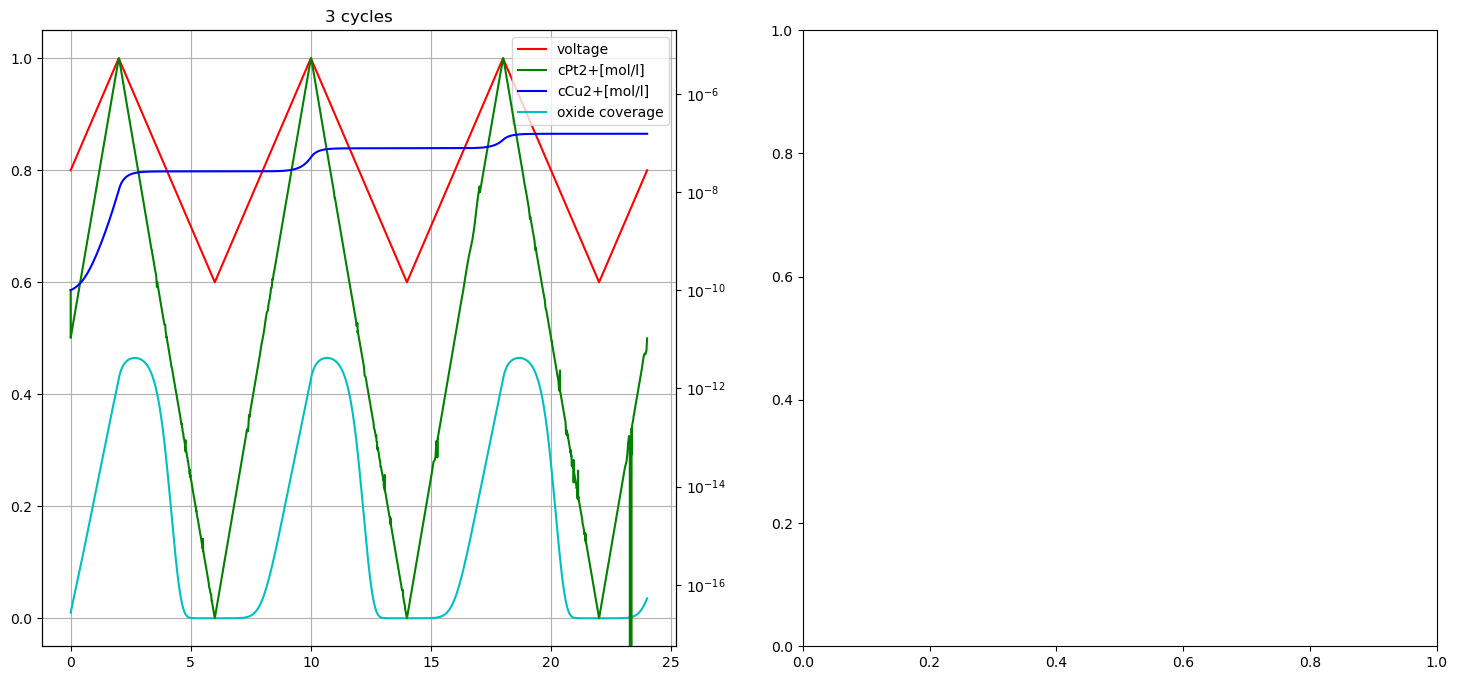

0.182958629542739
[1.04093616e-11 3.56468117e-02 1.52712666e-07]


In [433]:
#a lot of disolved particles... check graphs
#first reshape the matrix [vars,times]

f_plot(sol0)

X=sol0.y[:,-1]
stats = f_stats(X,ModPars,vec_c,vec_l)
print(stats[-1])
print(sol0.y[:3,-1])

0 30000.0
1 0.06
2 2.2000000000000003e-05
3 12000.0
4 0.5
5 2.0
6 1.03
7 20000.0
8 50000.0
9 10000.0
10 800000.0
11 45000.0
12 0.5
13 2.0
14 1.118
15 0.0
16 2.4
17 0.001
18 0.4
19 0.2
20 1.9999999999999998e-05
21 0.01
22 20000000.0
23 1.5
24 0.0
25 3.0
26 0.0
27 0.0
28 0.0
(1,)
(10,)
(344,)
round_max 600
0
mode 0: calculating 2 cycles
2
mode 1: calculating 1 cycle
Dt= 1.246263027191162
max_ratio= -3.5415487549412084
rounded down 2
	IF > 2: cycle 2
5
mode 1: calculating 1 cycle


/tmp/ipykernel_1983190/813804294.py:107: RuntimeWarning: divide by zero encountered in divide
  Xratios=Xin/dX
/tmp/ipykernel_1983190/813804294.py:107: RuntimeWarning: invalid value encountered in divide
  Xratios=Xin/dX


Dt= 1.1498267650604248
max_ratio= -3.8016536921544253
rounded down 3
	IF > 2: cycle 3
9
mode 1: calculating 1 cycle
Dt= 1.2000653743743896
max_ratio= -7.032799195683818
rounded down 5
	IF > 2: cycle 5
15
mode 1: calculating 1 cycle
Dt= 1.3433165550231934
max_ratio= -1.248272118994046
	IF < 2: repeate
16
mode 1: calculating 1 cycle
Dt= 1.2501955032348633
max_ratio= -45.47649889361644
rounded down 36
	IF > 2: cycle 36
53
mode 1: calculating 1 cycle
Dt= 1.448580265045166
max_ratio= -3.735952862759882
rounded down 2
	IF > 2: cycle 2
56
mode 1: calculating 1 cycle
Dt= 1.196470022201538
max_ratio= -4.360373471383482
rounded down 3
	IF > 2: cycle 3
60
mode 1: calculating 1 cycle
Dt= 1.1845002174377441
max_ratio= -11.303025320703293
rounded down 9
	IF > 2: cycle 9
70
mode 1: calculating 1 cycle
Dt= 1.21132230758667
max_ratio= -45.737110429147435
rounded down 36
	IF > 2: cycle 36
107
mode 1: calculating 1 cycle
Dt= 1.3549833297729492
max_ratio= -0.18688691096909912
	IF < 2: repeate
108
mode 1: 

(1000.0, 2000000000.0)

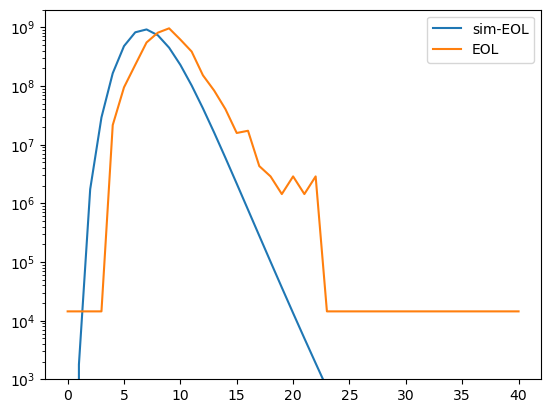

In [436]:
#set up optimisation
#one run
rateMax=50*10**-3 #mV/s
Umin=0.6 #V bot
Umax=1.0  #V top
Am=Umax-Umin #amplitude
t0=Am/(rateMax)
#t0=1200 #cycle duration in  [s]
#t0=data[-1,-1]
p=t0
nCyc = 3 #Number of cycles
tMax=nCyc*t0 #recalculate the final time
iDim = 20*nCyc  #number of observation points at which we save data
dt = tMax/(iDim)
ti = np.arange(0,tMax+dt,dt)

@jit(nopython=True)
def funcUPt_saw(x):
    rez=(2.*Am/p)*abs( (x-p/4.)%p - p/2.) + Umin
    return rez

#print(funcUPt_saw(0))

FCstate[2]=funcUPt_saw

ModPars0=np.copy(bimet_morelife_gen3c.ModPars)
for i,v in enumerate(ModPars0):
    print(str(i)+" "+str(v))
#print(ModPars0[14])
#ModPars0[14]=1.1
#ModPars[16]=3.
ModPars0[22]=0.001*10**9

#ModPars[9]=1.0*10**4    # nuForPt   Dissolution atmpto frequency [1/s]
#ModPars[10]=8*10**5  
#ModPars0[9]=5.0*10**3    # nuForPt   Dissolution atmpto frequency [1/s]
#ModPars0[10]=5.*10**7

pars0=(ModPars0,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])
sol,rez_X_4,rez_n_4,rez_stat_4 = bimet_morelife_gen3c.f_test_cycle_skip(MC=3000,round_factor=0.8, round_max_f=0.2,pars=pars0)

om=f_X_to_dist(sol.y[:,-1],vec_c,vec_l)
r_EOL=bimet_morelife_gen3c.f_om_to_r(om)
rez_norm_r_EOL = bimet_morelife_gen3c.f_norm_dist1d(vec_r,r)
plt.plot(rez_norm_r_EOL,label="sim-EOL")

#plt.plot(rez_norm_r_BOL,label="BOL")

plt.plot(hist_fix_EOL,label="EOL")
plt.legend()
#plt.plot(rez_norm_r)
plt.yscale("log")
plt.ylim([1e3,2e9])

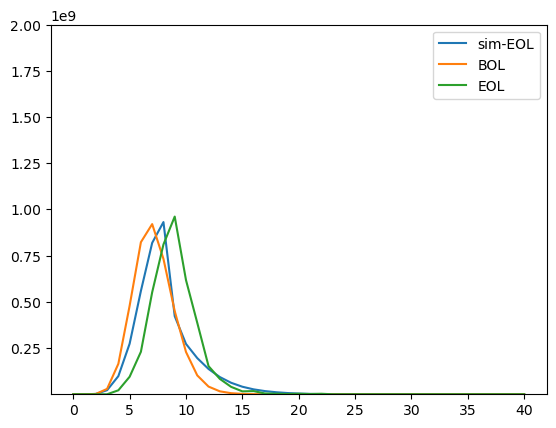

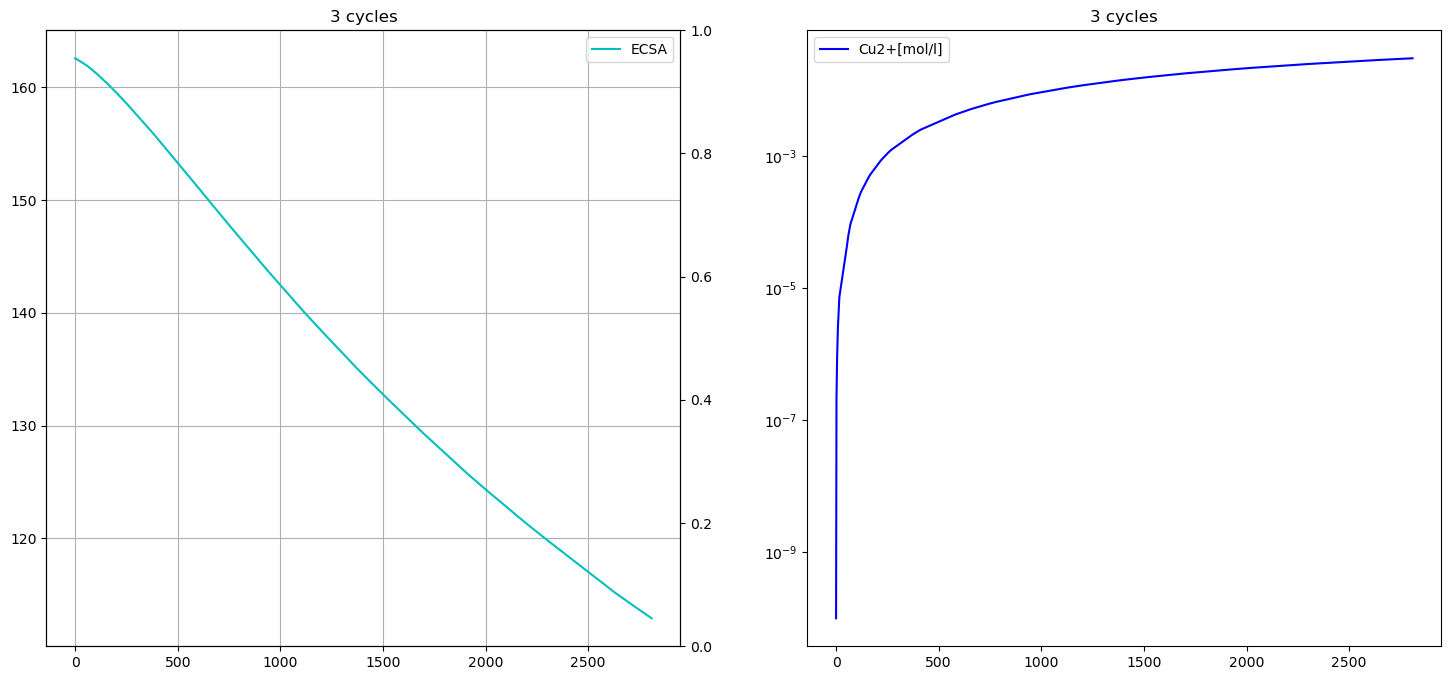

In [440]:
om=f_X_to_dist(sol.y[:,-1],vec_l,vec_c)
om=f_X_to_dist(rez_X_4[-1,:],vec_l,vec_c)
r_EOL=bimet_morelife_gen3c.f_om_to_r(om)
rez_norm_r_EOL = bimet_morelife_gen3c.f_norm_dist1d(vec_r,r_EOL)
plt.plot(rez_norm_r_EOL,label="sim-EOL")

#plt.plot(rez_norm_r_BOL,label="BOL")
plt.plot(rez_norm_r_BOL,label="BOL")

plt.plot(hist_fix_EOL,label="EOL")
plt.legend()
#plt.plot(rez_norm_r)
#plt.yscale("log")
plt.ylim([1e3,2e9])

#plt.plot(rez_norm_r_EOL,label="sim-EOL")

#plot Pt,Cu,...
def f_plot_stats(rez_n,rez_stat,rez_X,fname="defname.png"):
    res_r=rez_stat[:,2]
    res_ECSA=rez_stat[:,5]
    res_Pt=rez_stat[:,-2]
    res_Cu=rez_stat[:,-1]
    
    fig, axes = plt.subplots(1,2,figsize=(18, 8))
    p4,=axes[0].plot(rez_n,res_ECSA,color=color4, label="ECSA")
    #p1,=axes[0].plot(rez_n,res_r,color=color1, label="voltage")
    
    axes[0].grid(True)
    axes2=axes[0].twinx()
    
    #p2,=axes2.plot(rez_n,res_Pt,color=color2, label="Pt2+[mol/l]")
    #p3,=axes2.plot(rez_n,res_Cu,color=color3, label="Cu2+[mol/l]")
    #axes2.set_yscale('log')
    
    #lns = [p1,p2,p3,p4]
    lns = [p4]

    axes[0].legend(handles=lns, loc='best')
    axes[0].set_title("3 cycles")

    #p11,=axes[1].plot(rez_n,rez_X_4[:,0],color=color2, label="Pt2+[mol/l]")
    p12,=axes[1].plot(rez_n,rez_X_4[:,2],color=color3, label="Cu2+[mol/l]")
    #rez_X_4[:,1]
    lns=[p12]
    axes[1].legend(handles=lns, loc='best')
    axes[1].set_title("3 cycles")
    axes[1].set_yscale('log')
    
    plt.savefig(fname)
    plt.show()
#rez_X_4,rez_n_4,rez_stat_4
#rez_X_4[:,1]
f_plot_stats(rez_n_4,rez_stat_4,rez_X_4,fname="defname.png")

#print price at begining and end!
print(f_price())

rezultat = differential_evolution(f_price_direct, bounds=bounds_alter,x0=vek_0_alter,polish=True,popsize=100, maxiter=200, callback=f_callback, tol=0.0001, disp = True,updating="deferred",workers=-1)


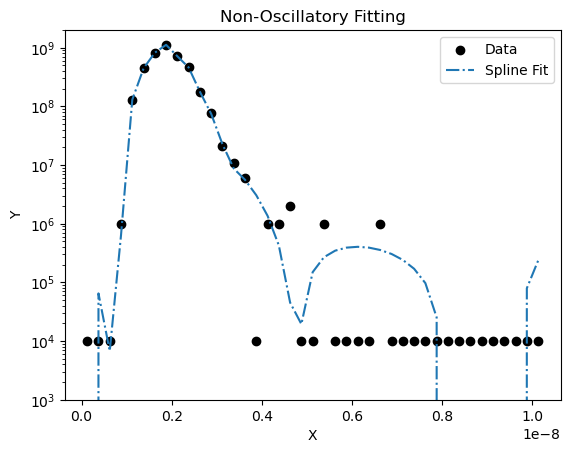

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


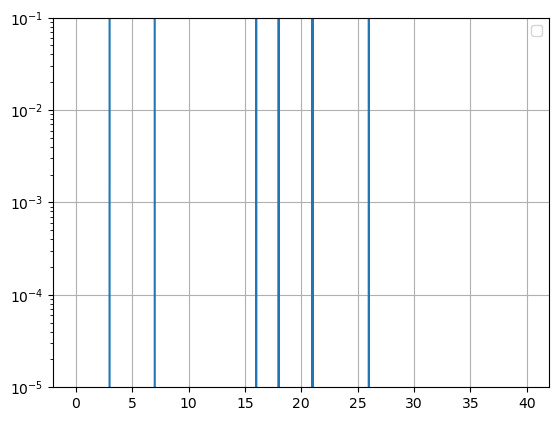

In [482]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline

# Load your data (replace with your actual data)
# Example: x = np.array([...]), y = np.array([...])
y = hist_fix
x = vec_r

lambda_penalty = 15e13 # Adjust to control smoothness
spline = UnivariateSpline(x, y, s=lambda_penalty)
y_spline = spline(x)
#y_spline_fit = spline(x_fit)

# Plot results
plt.scatter(x, y, label="Data", color='black')
#plt.plot(x_fit, y_exp_fit, label="Exponential Fit", linestyle='dashed')
#plt.plot(x_fit, y_poly_fit, label="Polynomial Fit", linestyle='dotted')
plt.plot(x, y_spline, label="Spline Fit", linestyle='dashdot')
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.yscale('log')
plt.ylim([1e3,2e9])

plt.title("Non-Oscillatory Fitting")
plt.show()

h1=np.diff(hist_fix)
h2=np.diff(h1)
h3=np.diff(h2)
#plt.plot(h1)
plt.plot(np.pad(h1, (1,0 ), mode='constant', constant_values=0)/hist_fix)
#plt.plot(h3)

cN=np.cumsum(hist[0])
cN=cN/cN[-1]

cS=np.cumsum(hist[0]*vec_r*vec_r)
cS=cS/cS[-1]

cV=np.cumsum(hist[0]*vec_r*vec_r*vec_r)
cV=cV/cV[-1]

plt.plot(vec_r,1.-cN,label="N")
plt.plot(vec_r,1.-cS,label="S")
plt.plot(vec_r,1.-cV,label="V")

plt.yscale('log')
plt.ylim([1e-5,1e-1])

plt.legend()
plt.grid()
#cumulative surface and volume
#cumulative pt and cu 

In [29]:
#TODO smooothing data I give up at this point, must pparametrise

# v resnici premaknem po filingu dol na roko.
#yracunam in poogledam, kako velike so raazlike. do es
from scipy.optimize import LinearConstraint
bounds=[(0.4,0.7)]

#var naj bo nivo perturbacij
var=3e9
eps=1e3

for i,r in enumerate(hist_fix):
    bounds.append((eps,np.sum(hist_moved)))

vek_0=np.append([5e-01],hist_moved)

print(bounds)
#print(vek_0)
#print(len(bounds))
#print(len(vek_0))

#print(len(hist_moved)) 
#print(len(vek_0)) 
print(f_price_direct(vek_0))
print(f_price_direct(vek_0))

"""
for i in range(10):
    vek_test= np.random.uniform(1, 0, size=len(vek_0))*np.sum(hist_moved)
    vek_test[0]=0.5
    print(vek_test)
    print(f_price_direct(vek_test))
"""

hist_alter=hist_moved/max(hist_moved)
vek_0_alter=np.append([5e-01],hist_alter)
bounds_alter=[(0.4,0.7)]
eps=1e-7
for i,r in enumerate(hist_alter):
    bounds_alter.append((eps,1.))

#linear constrint, probably doesnt matter, since i
A = np.array([np.ones( len(hist_alter)+1 )])
A[0,0]=0
b_val=np.sum(hist_alter)
b = np.array([b_val])
constraint = LinearConstraint(A, lb=b-eps, ub=b+eps)

#nonconstraint = NonlinearConstraint(lambda x: x[0] + x[1], -np.inf, 1)

#vek_0=[ 6.575e-01 , 2.699e-01 , 1.003e-02 , 1.325e+00]

print(A)
print(b)

#rezultat = differential_evolution(f_price_direct, bounds=bounds_alter,x0=vek_0_alter,polish=True,popsize=100, maxiter=200, callback=f_callback, tol=0.0001, disp = True,updating="deferred",workers=-1,constraints=(constraint,))
rezultat = differential_evolution(f_price_direct, bounds=bounds_alter,x0=vek_0_alter,polish=True,popsize=100, maxiter=200, callback=f_callback, tol=0.0001, disp = True,updating="deferred",workers=-1)

#rezultat = differential_evolution(f_price_direct, bounds=bounds,x0=vek_0,polish=True,popsize=100, maxiter=200, callback=f_callback, tol=0.0001, disp = True,updating="deferred",workers=-1,constraints=(constraint,))
#rezultat = differential_evolution(f_price_direct, bounds=bounds,x0=vek_0,polish=True,popsize=100, maxiter=200, callback=f_callback, tol=0.0001, disp = True,updating="deferred",workers=-1)


[(0.4, 0.7), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (1000.0, 4000238568.588471), (

Process ForkPoolWorker-317:
Process ForkPoolWorker-314:
Process ForkPoolWorker-316:


KeyboardInterrupt: 

(1000.0, 2000000000.0)

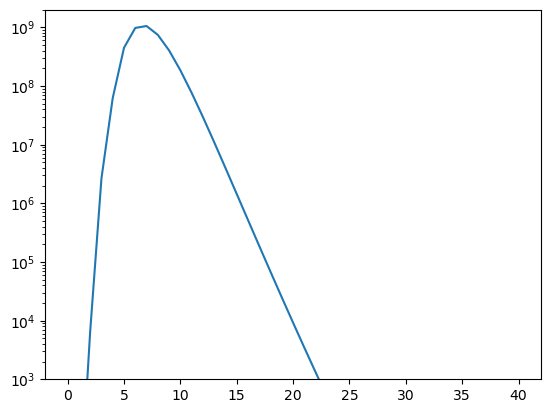

In [370]:
plt.plot(rez_norm_r_EOL,label="sim-EOL")
plt.yscale("log")
plt.ylim([1e3,2e9])


In [109]:
#test if copper after 3 cycs is the same in 
sol=bimet_morelife_gen3c.f_run_cyc(X0,Am/(rateMax),0,3,pars0,tol_r,tol_a)
X=sol.y[:,-1]
stats = f_stats(X,ModPars,vec_c,vec_l)
print(stats[-1])
print(sol.y[:3,-1])

0.182958628529153
[1.06554848e-11 3.56466367e-02 1.53725738e-07]


In [99]:
#FCstate[2]=funcUPt_saw
pars=(ModPars,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])
#ModPars= np.copy(bimet_morelife_gen3c.ModPars)

ModPars0=np.copy(bimet_morelife_gen3c.ModPars)
#pars0=(ModPars0,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])
pars0=(ModPars0,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])
sol=bimet_morelife_gen3c.f_run_cyc(X0,Am/(rateMax),0,10,pars0,tol_r,tol_a)
#works
#sol=bimet_morelife_gen3c.f_run_cyc(X0,Am/(rateMax),0,10,pars,tol_r,tol_a)

In [116]:
ModPars0=np.copy(bimet_morelife_gen3c.ModPars)
for i,v in enumerate(ModPars0):
    print(str(i)+" "+str(v))
#ModPars=pars[0]

0 30000.0
1 0.06
2 2.2000000000000003e-05
3 12000.0
4 0.5
5 2.0
6 1.03
7 20000.0
8 50000.0
9 10000.0
10 800000.0
11 45000.0
12 0.5
13 2.0
14 1.118
15 0.0
16 2.4
17 0.001
18 0.4
19 0.2
20 1.9999999999999998e-05
21 0.01
22 20000000.0
23 1.5
24 0.0
25 3.0
26 0.0
27 0.0
28 0.0


3748
(1,)
(10,)
(344,)
round_max 600
0
mode 0: calculating 2 cycles
2
mode 1: calculating 1 cycle
Dt= 0.12768077850341797
max_ratio= -8.703876861467121
rounded down 6
	IF > 2: cycle 6
9
mode 1: calculating 1 cycle


/tmp/ipykernel_1983190/813804294.py:107: RuntimeWarning: divide by zero encountered in divide
  Xratios=Xin/dX
/tmp/ipykernel_1983190/813804294.py:107: RuntimeWarning: invalid value encountered in divide
  Xratios=Xin/dX


Dt= 0.12955141067504883
max_ratio= -59.70408999004188
rounded down 47
	IF > 2: cycle 47
57
mode 1: calculating 1 cycle
Dt= 0.12981486320495605
max_ratio= -0.12951661291007113
	IF < 2: repeate
58
mode 1: calculating 1 cycle
Dt= 0.11593079566955566
max_ratio= -0.19826054955868547
	IF < 2: repeate
59
mode 1: calculating 1 cycle
Dt= 0.12925267219543457
max_ratio= -0.8187420347857329
	IF < 2: repeate
60
mode 1: calculating 1 cycle
Dt= 0.11495566368103027
max_ratio= -5.977926607938863
rounded down 4
	IF > 2: cycle 4
65
mode 1: calculating 1 cycle
Dt= 0.12799954414367676
max_ratio= -66.18932120154241
rounded down 52
	IF > 2: cycle 52
118
mode 1: calculating 1 cycle
Dt= 0.1159219741821289
max_ratio= -0.1289255995798528
	IF < 2: repeate
119
mode 1: calculating 1 cycle
Dt= 0.11494994163513184
max_ratio= -0.19341536297534487
	IF < 2: repeate
120
mode 1: calculating 1 cycle
Dt= 0.12903404235839844
max_ratio= -0.7826809260627003
	IF < 2: repeate
121
mode 1: calculating 1 cycle
Dt= 0.114979743957519

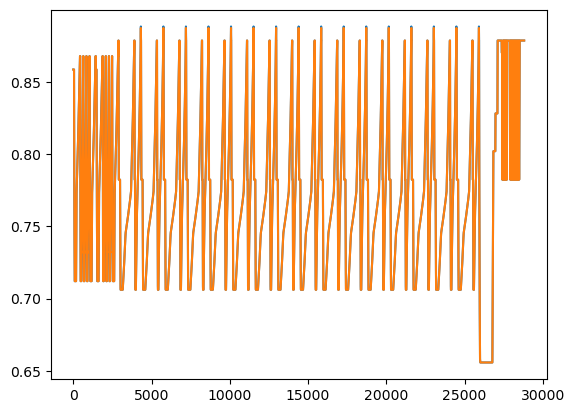

In [342]:
#cycle skip input 3K cycles. try to run with several procesors in prder to speed up
from datetime import datetime

#pars0=(ModPars0,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])

ModPars0=np.copy(bimet_morelife_gen3c.ModPars)
#print(ModPars0[14])
ModPars0[14]=1.118
ModPars[16]=1.
ModPars0[22]=0.01*10**9

#ModPars[9]=1.0*10**4    # nuForPt   Dissolution atmpto frequency [1/s]
#ModPars[10]=8*10**5  
ModPars0[9]=5.0*10**3    # nuForPt   Dissolution atmpto frequency [1/s]
ModPars0[10]=5.*10**7
pars0=(ModPars0,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])


#set hdv cycle run
#read hd cycle:
file_path = "data_HD_cycle.xlsx"  # Update with your actual file path
df_HD = pd.read_excel(file_path,skiprows=0)  # Specify engine for old .xls format

def moving_average_padded(signal, window_size):
    pad_width = window_size // 2
    padded_signal = np.pad(signal, pad_width, mode='edge')  # Replicate edges
    smoothed_signal = np.convolve(padded_signal, np.ones(window_size) / window_size, mode='valid')
    return smoothed_signal

secs=df_HD.iloc[:, 0].dropna().to_numpy()
sig=df_HD.iloc[:, 1].dropna().to_numpy()
# Apply smoothing with edge handling
window_size = 3
sig_smooth = moving_average_padded(sig, window_size)

plt.plot(sig)
plt.plot(secs,sig_smooth)

#construct interpolation function. and jit it!
@jit(nopython=True,parallel=False)
def funcUPt_HDV(x_vals):
    return np.interp(x_vals , secs , sig_smooth)


#run one cycle and time it.
FCstate[2]=funcUPt_HDV
pars=(ModPars,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])

def f_cyc_HD():
    ti=np.linspace(secs[0],secs[-1],10000)
    #ti=ti[:100]
    #print(ti)
    t0=time.time()
    sol0 = solve_ivp(f_dfdt, (ti[0],ti[-1]), X0, method='LSODA', t_eval=None, args=pars, rtol  = tol_r, atol = tol_a)
    #sol1=bimet_morelife_gen3c.f_run_cyc(X0,Am/(rateMax),0,3,pars,tol_r,tol_a)
    #t1=time.time()
    #print("time= "+str(t1-t0))
    return sol0

def f_HDV_cycle_skip(MC=3000,round_factor=0.8, round_max_f=0.2,pars=pars0):
    
    ModPars=pars[0]
    
    tStart = time.time()

    #start cycles
    s_cycs=2
    #all positive bins never happens in this cycling
    d_cyc=2
    #finish steps
    finish_steps=3
    
    t0=0
    rez_stat_4=bimet_morelife_gen3c.f_stats(X0,ModPars,vec_c,vec_l)
    rez_stat_4=np.array(rez_stat_4)
    rez_t_4=[t0]
    Xin=X0
    rez_X_4=np.array(X0)
    rez_n_4=[0]
    
    print(np.shape(rez_n_4))
    print(np.shape(rez_stat_4))
    print(np.shape(rez_X_4))

    round_max = int(round_max_f*MC)
    print("round_max "+str(round_max))
    
    current_date = datetime.now().strftime('%Y-%m-%d')
    base_filename = f"data_"+str(round_max)+f"_sim_{current_date}.txt"
    filename =  bimet_morelife_gen3c.f_create_unique_filename(base_filename)
    #f_append_to_file(filename,str(0) + " " + str(X0) )
    
    i=0
    while i<MC:
        #print(np.shape(rez_n_4))
        #print(np.shape(rez_stat_4))
        #print(np.shape(rez_X_4))
        print(i)
        #initialise maybe calc a few cycles
        #this remains the same as previous versions
        if i<s_cycs:
            print("mode 0: calculating "+str(s_cycs)+" cycles")
            #sol=f_run_cyc(Xin,0,s_cycs)
            #sol=bimet_morelife_gen3c.f_run_cyc(Xin,Am/(rateMax),0,s_cycs)
            sol=f_cyc_HD()
            Xin=sol.y[:,-1]
            t0=sol.t[-1]
    
            #trez=Xin
            #trez_stat=f_stats(trez,ModPars,vec_c,vec_l)
            #rez_stat_4=np.vstack((rez_stat_4,trez_stat))
            #rez_t_2.append(t0)
    
            #rez_X_4=np.vstack((rez_X_4,Xin))
            
            i=i+s_cycs
            #rez_n_4.append(i)
            
        else:
            print("mode 1: calculating "+str(1)+" cycle")
            #calc one cycle to get dX
            #set previous val 
            X01=Xin
            #run a cycle and calculate dX
            #sol=bimet_morelife_gen3c.f_run_cyc(Xin,Am/(rateMax),0,1)
            tStart = time.time()
            sol=f_cyc_HD()
            tEnd = time.time()
            print("Dt= "+str(tEnd-tStart))

            Xin=sol.y[:,-1]
    
            if np.any(Xin[4:])<=0:
                print("encountered negative value")
                break
            
            dX=bimet_morelife_gen3c.f_calc_delta(X01,Xin,ModPars,vec_c,vec_l)
            
            i=i+1
            #this may need to be changed in ver 2 in order to fix indices
            Xin=sol.y[:,-1]
            #we increment this anyways
    
            #check how much iteration we can afford. 
            #loop trough all the ratios in diferentials.
            #increment dX
            #print(min(abs(Xin)))
            #print(min(abs(dX)))
            Xratios=Xin/dX
            
            #check wat is the smallest negative value and also report index.
            max_ratio= highest_negative = np.max(Xratios[Xratios < 0]) if np.any(Xratios < 0) else None
            
            print("max_ratio= "+str(max_ratio))
            #treshold = 2.
    
            #all positive for some reason
            #not very likely
            if max_ratio == None:
                print("\tIF = all positive: keep going")
                #skip d_cycs
                Xin=Xin+dX*d_cyc
                i=i+d_cyc
    
            #we can actually skip a few steps
            elif abs(max_ratio) > 2:
                #rounded_down = max_ratio
                #print("rounded down "+str(rounded_down))
                #rounded_down = round_factor
                #print("rounded down "+str(rounded_down))
                #rounded_down = max_ratio*round_factor
                #print("rounded down "+str(rounded_down))
                #rounded_down = abs(max_ratio*round_factor)
                #print("rounded down "+str(rounded_down))
                rounded_down = int(abs(max_ratio*round_factor))
                #print("rounded down "+str(rounded_down))
                rounded_down = min( rounded_down ,round_max)
                #print("rounded down "+str(rounded_down))
                #rounded_down=max(rounded_down,1)
                print("rounded down "+str(rounded_down))
                #check if we can finish get close and do a few loops
                #do some loops
                #finish up
                #break
                if i+rounded_down >= MC:
                    print("finishing")
                    #first do some steps then finish up
                    if MC-i > finish_steps:
                        d_cyc=MC-i-finish_steps
                        Xin=Xin+dX*d_cyc  
                        sol=f_cyc_HD()
                        i=MC
                    #just finish up
                    else:
                        sol=f_cyc_HD()
                        i=MC
                    break
                
                print("\tIF > 2: cycle "+ str(rounded_down))
                Xin=Xin+dX*rounded_down
                i=i+rounded_down
    
            #we cant propagate
            else:
                print("\tIF < 2: repeate")
                #we have only calculated 
                pass
    
            #record vector and stats and index values at the end.
            #f_append_to_file(filename,str(i) + " " + str(Xin) )
            
        rez_X_4=np.vstack((rez_X_4,Xin))
        trez_stat=f_stats(Xin,ModPars,vec_c,vec_l)
        rez_stat_4=np.vstack((rez_stat_4,trez_stat))
        rez_n_4.append(i)

    #w_string=str(i) + " " + np.array2string(Xin, threshold=np.inf, precision=8, separator=", ").replace("\n", "")
    #bimet_morelife_gen3c.f_append_to_file(filename,w_string)
    #tEnd = time.time()
    #bimet_morelife_gen3c.f_append_to_file(filename,str(tEnd-tStart))

    print("finish:" + str(i))
    #return rez_X_4,rez_stat_4,rez_n_4
    return sol,rez_X_4,rez_n_4,rez_stat_4    


ncycs=int(30000*3600/secs[-1])
print(ncycs)

#sol=bimet_morelife_gen3c.f_run_cyc(X0,Am/(rateMax),0,1,pars,tol_r,tol_a)
#sol=bimet_morelife_gen3c.f_run_cyc(X0,Am/(rateMax),0,10,pars0,tol_r,tol_a)
#sol,rez=f_HDV_cycle_skip(MC=9,round_factor=0.8, round_max_f=0.2)

sol,rez_X_4,rez_n_4,rez_stat_4 = f_test_cycle_skip(MC=3000,round_factor=0.8, round_max_f=0.2)
#print(sol.y[:3,-1])

In [ ]:
Xin,Am/(rateMax),0,finish_steps,pars,tol_r,tol_a

sol=f_cyc_HD()
Xin=sol.y[:,-1]
dX=bimet_morelife_gen3c.f_calc_delta(X0,Xin,ModPars,vec_c,vec_l)            

Xin=sol.y[:,-1]
Xratios=Xin/dX
max_ratio= highest_negative = np.max(Xratios[Xratios < 0]) if np.any(Xratios < 0) else None
print("max_ratio= "+str(max_ratio))

In [ ]:
print(tol_r)
print(tol_a)

X=sol.y[:,-1]
stats = f_stats(X0,ModPars,vec_c,vec_l)
print(stats)
X=sol.y[:,-1]
stats = f_stats(X,ModPars,vec_c,vec_l)
print(stats)

In [ ]:

X=sol.y[:,-1]
om=bimet_morelife_gen3c.f_X_to_dist(X,vec_l,vec_c)
r=bimet_morelife_gen3c.f_om_to_r(om)
rez_norm_r_end = bimet_morelife_gen3c.f_norm_dist1d(vec_r,r)

plt.plot(hist_fix_EOL,label="EOL")
#plt.plot(hist_fix_BOL,label="BOL")
#plt.plot(hist_moved)
#plt.plot(r)
plt.plot(rez_norm_r,label="BOL")
plt.plot(rez_norm_r_end,label="BOL_calc")

plt.legend()

#plt.plot(np.abs(rez_norm_r-hist_fix))
#plt.yscale("log")
#plt.ylim([1e3,4e9])

#dist_bins_om ,vec_c, vec_l = bimet_morelife_gen3c.f_start_dist_cin(hist_fix,lmin1=0.25,lmax1=5.,cmin1=0.25,MPars=ModPars, loc_l=0.25*3, scale_l=0.25*0.5)
#vek_in = np.append([0.25*3],hist_fix)
    
#f_price_direct(vek_in)
#plt.plot(hist[1][1:],hist[0])
plt.yscale("log")
plt.ylim([1e3,2e9])
#plt.imshow(dist_bins_om)

#print(f_penal(hist_fix))
#print(hist_fix)

print("THIS IS FINE!")
#TODO resutl distribution

28807
28807
28807


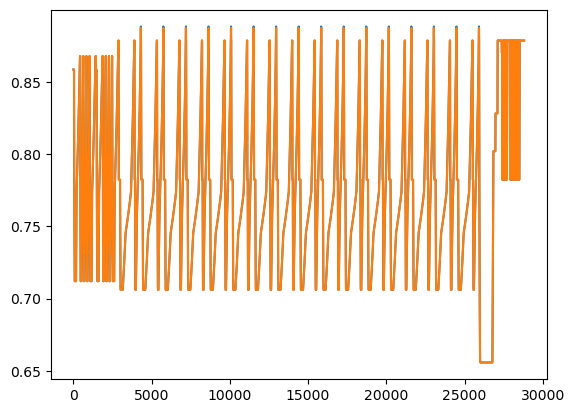

In [320]:
#read hd cycle:
file_path = "data_HD_cycle.xlsx"  # Update with your actual file path
df_HD = pd.read_excel(file_path,skiprows=0)  # Specify engine for old .xls format

def moving_average_padded(signal, window_size):
    pad_width = window_size // 2
    padded_signal = np.pad(signal, pad_width, mode='edge')  # Replicate edges
    smoothed_signal = np.convolve(padded_signal, np.ones(window_size) / window_size, mode='valid')
    return smoothed_signal


short=-2
secs=df_HD.iloc[:short, 0].dropna().to_numpy()
sig=df_HD.iloc[:short, 1].dropna().to_numpy()
# Apply smoothing with edge handling
window_size = 3
sig_smooth = moving_average_padded(sig, window_size)

plt.plot(secs,sig)
plt.plot(secs,sig_smooth)

#construct interpolation function. and jit it!
@jit(nopython=True,parallel=False)
def funcUPt_HDV(x_vals):
    #secs[-1]
    return np.interp(x_vals%secs[-1] , secs , sig_smooth)

#interpolate result
#plot graph
#make internal cycle

print(len(sig))
print(len(secs))
print(len(sig_smooth))

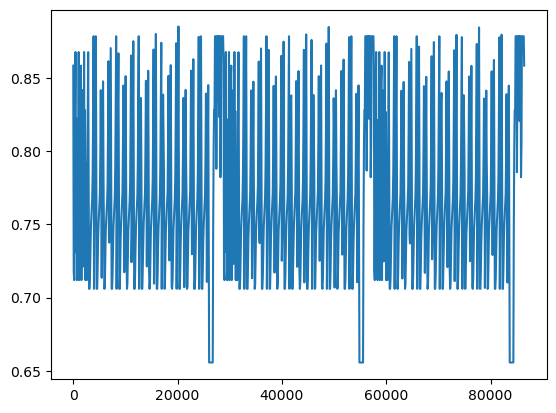

In [321]:
ti=np.linspace(secs[0],secs[-1]*3,1000)
out=[]
for i in ti:
    out.append(funcUPt_HDV(i))
plt.plot(ti,out)

In [322]:
#run one cycle and time it.

FCstate[2]=funcUPt_HDV
pars=(ModPars,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])

def f_cyc_HD(X0,nc,pars,tol_r,tol_a):
    #here hdv is hardcoded in 
    ti=np.linspace(secs[0],secs[-1]*nc,10000)
    
    Xin=np.copy(X0)
    
    sol0 = solve_ivp(f_dfdt, (ti[0],ti[-1]), Xin, method='LSODA', t_eval=ti, args=pars, rtol  = tol_r, atol = tol_a)

    #ti=ti[:100]
    #print(ti)
    #t0=time.time()
    #for i in range(nc):
        #sol0 = solve_ivp(f_dfdt, (ti[0],ti[-1]), Xin, method='LSODA', t_eval=None, args=pars, rtol  = tol_r, atol = tol_a)
        #Xin=np.copy(sol0.y[:,-1])
    #sol1=bimet_morelife_gen3c.f_run_cyc(X0,Am/(rateMax),0,3,pars,tol_r,tol_a)
    #t1=time.time()
    #print("time= "+str(t1-t0))
    return sol0

In [323]:
sol=f_cyc_HD(X0,3,pars,tol_r,tol_a)
f_plot(sol)
print(len(sol.t))

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


KeyboardInterrupt: 

In [ ]:
sol=f_cyc_HD(X0,6,pars,tol_r,tol_a)
f_plot(sol)
print(len(sol.t))

/home/matej/miniconda3/envs/bimetal-numba/lib/python3.8/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.5672662370105D+05   r2 =                  NaN


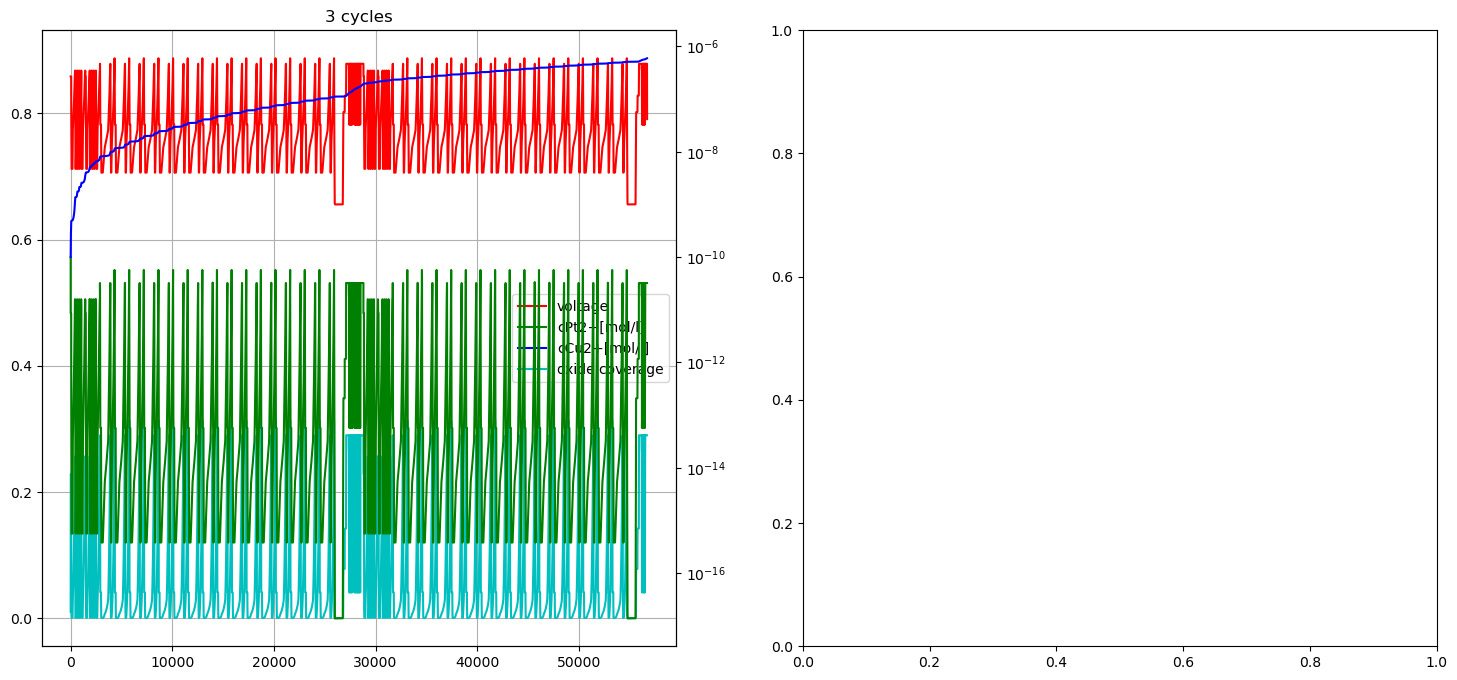

nan
[nan nan nan]


In [258]:

sol=f_cyc_HD(X0,3,pars,tol_r,tol_a)
f_plot(sol)
X=sol.y[:,-1]
stats = f_stats(X,ModPars,vec_c,vec_l)
print(stats[-1])
print(sol.y[:3,-1])

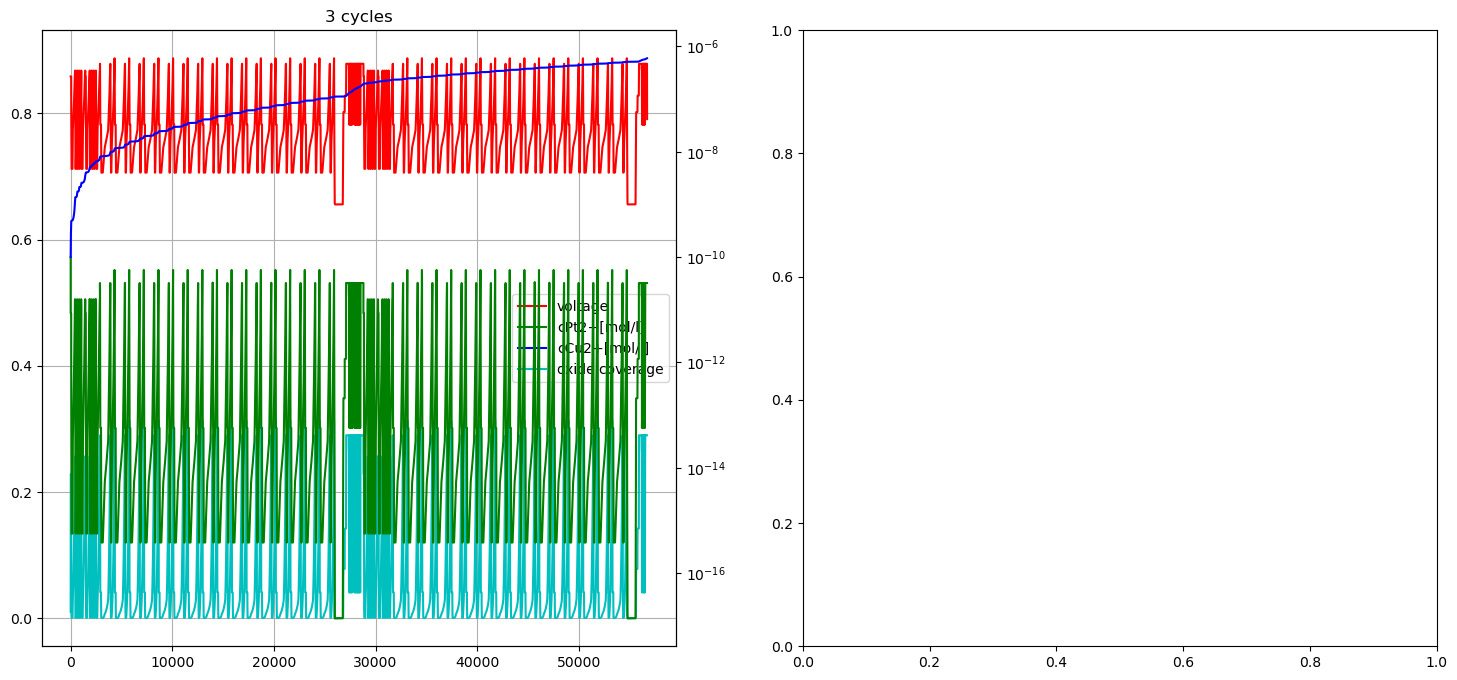

[1.44644825e-29 1.95713483e-28 4.05256714e-28 ... 2.48111343e+11
 2.50046371e+11            nan]
(array([113457]),)


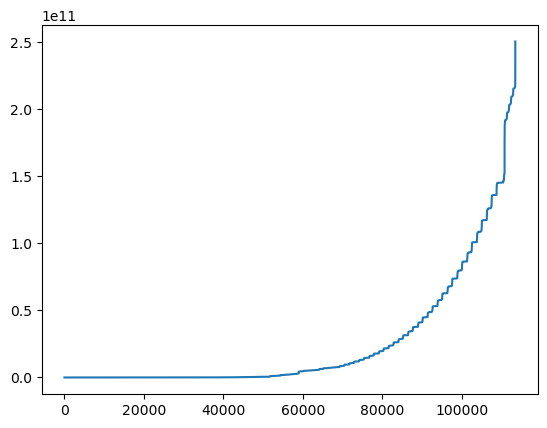

In [261]:
f_plot(sol) #problem in running multiple cycles

print(sol.y[-1,:])
#last values are problematic Nans
#sol.t
plt.plot(sol.y[-1,:])
nan_indices = np.where(np.isnan(sol.y[-1,:]))
print(nan_indices)

In [240]:
Xin=sol.y[:,-1]
dX=bimet_morelife_gen3c.f_calc_delta(X0,Xin,ModPars,vec_c,vec_l)            

#Xin=sol.y[:,-1]
Xratios=Xin/dX
max_ratio= highest_negative = np.max(Xratios[Xratios < 0]) if np.any(Xratios < 0) else None
print("max_ratio= "+str(max_ratio))

ncycs=int(30000*3600/secs[-1])
print(ncycs)
#number of cycles
#run and record values at intervals


max_ratio= -0.47425228078966253
3748


/tmp/ipykernel_1983190/1850878988.py:5: RuntimeWarning: divide by zero encountered in divide
  Xratios=Xin/dX
/tmp/ipykernel_1983190/1850878988.py:5: RuntimeWarning: invalid value encountered in divide
  Xratios=Xin/dX


In [463]:
#print(X0)
print(len(X0))
print(len(vec_c))
print(len(vec_l))
print(len(vec_c)*len(vec_l))

#X0 majhen

print(bimet_morelife_gen3c.f_stats(X0,ModPars0,vec_c,vec_l))

sol,rez,rez_n,rez_stats=f_test_cycle_skip(MC=9,round_factor=0.8, round_max_f=0.2)


344
23
19
437


IndexError: index 344 is out of bounds for axis 0 with size 344

In [72]:
#copy Modpars in order to start with starting parameters
##import funcions, set up variables
#ti=bimet_morelife_gen3c.ti
#X0=bimet_morelife_gen3c.X0
f_dfdt=bimet_morelife_gen3c.f_dfdt
f_dc_dl=bimet_morelife_gen3c.f_dc_dl
f_stats=bimet_morelife_gen3c.f_stats
f_calc_delta=bimet_morelife_gen3c.f_calc_delta
f_norm_dist1d = bimet_morelife_gen3c.f_norm_dist1d
f_sum_abs = bimet_morelife_gen3c.f_sum_abs
f_sum_squares = bimet_morelife_gen3c.f_sum_squares 
f_dist_to_X = bimet_morelife_gen3c.f_dist_to_X
f_X_to_dist = bimet_morelife_gen3c.f_X_to_dist
f_mean = bimet_morelife_gen3c.f_mean
f_om_to_surf = bimet_morelife_gen3c.f_om_to_surf
fun_fact = bimet_morelife_gen3c.f_fun_fact
f_flat_res_om = bimet_morelife_gen3c.f_flat_res_om
f_cl_to_rl_rc=bimet_morelife_gen3c.f_cl_to_rl_rc

f_trans_x_to_om = bimet_morelife_gen3c.f_trans_x_to_om
f_om_to_ptcu = bimet_morelife_gen3c.f_om_to_ptcu

funccHp = bimet_morelife_gen3c.funccHp
funcT = bimet_morelife_gen3c.funcT
funcUPt_const = bimet_morelife_gen3c.funcUPt_const
#import funcions, set up variables
#ti=bimet_morelife_gen3c.ti
#X0=bimet_morelife_gen3c.X0
f_dfdt=bimet_morelife_gen3c.f_dfdt
f_dc_dl=bimet_morelife_gen3c.f_dc_dl
f_stats=bimet_morelife_gen3c.f_stats
f_calc_delta=bimet_morelife_gen3c.f_calc_delta
f_norm_dist1d = bimet_morelife_gen3c.f_norm_dist1d
f_sum_abs = bimet_morelife_gen3c.f_sum_abs
f_sum_squares = bimet_morelife_gen3c.f_sum_squares 
f_dist_to_X = bimet_morelife_gen3c.f_dist_to_X
f_X_to_dist = bimet_morelife_gen3c.f_X_to_dist
f_mean = bimet_morelife_gen3c.f_mean
f_om_to_surf = bimet_morelife_gen3c.f_om_to_surf
fun_fact = bimet_morelife_gen3c.f_fun_fact
f_flat_res_om = bimet_morelife_gen3c.f_flat_res_om
f_cl_to_rl_rc=bimet_morelife_gen3c.f_cl_to_rl_rc

f_trans_x_to_om = bimet_morelife_gen3c.f_trans_x_to_om
f_om_to_ptcu = bimet_morelife_gen3c.f_om_to_ptcu
f_om_to_r=bimet_morelife_gen3c.f_om_to_r

funccHp = bimet_morelife_gen3c.funccHp
funcT = bimet_morelife_gen3c.funcT
funcUPt_const = bimet_morelife_gen3c.funcUPt_const
funcUPt_saw = bimet_morelife_gen3c.funcUPt_saw

#reinport parameters important copy! check th ecode elsware
ModPars=np.copy(bimet_morelife_gen3c.ModPars)
FCstate=bimet_morelife_gen3c.FCstate

"""
vars=[14,16,22]
vek_in=[9.76890810e-01, 3.51880947e+00, 8.83717740e+07]
vek_in=[0.93, 2., 0.03*10**9]
vek_in=[9.00169568e-01, 1.36473906e+00, 2.13592853e+07]
for i,j in enumerate(vars):
    ModPars[j]=vek_in[i]
"""

vek=[7.500e-01,1.200e-01,1.978e+00]
dist_bins_om ,vec_c, vec_l = bimet_morelife_gen3c.f_start_dist_alter(lmin=0.25,lmax=5,cmin=0.25,cmax=14,MPars=ModPars, loc_l=0.25*3, scale_l=0.25, s_c=vek[0], loc_c=vek[1], scale_c=vek[2])
###set simulation marameters: material params, bins in c and l, input functions

C,L = np.meshgrid(vec_c,vec_l)

rateMax=50*10**-3 #mV/s
Umin=0.6 #V bot
Umax=1.0  #V top
Am=Umax-Umin #amplitude
t0=Am/(rateMax)
#t0=1200 #cycle duration in  [s]
#t0=data[-1,-1]
p=t0
nCyc = 3 #Number of cycles
tMax=nCyc*t0 #recalculate the final time
#tMax in hours

# AST voltage profile
@jit(nopython=True)
def funcUPt_saw(x):
    return (2.*Am/p)*abs( (x-p/4.)%p - p/2.) + Umin
FCstate[2]=funcUPt_saw

#Nsecs=t_rates[-1]
#tMax=Nsecs
iDim = 20*nCyc  #number of observation points at which we save data
dt = tMax/(iDim)
ti = np.arange(0,tMax+dt,dt)

#ti = bimet_morelife_gen3c.ti

nSt = 3 
#number of bins
nc = len(vec_c)
nl = len(vec_l)
# total number of variables
nSys = nSt+nc*nl

### set initial distribution
#initial states
X0 = np.zeros(nSys)
# cathode
#fill the bins starting vector
X0[0]=1.0*10**-10
X0[1]=1.0*10**-2
X0[2]=1.0*10**-10
X0[3:]=dist_bins_om.flatten()

#print("X0")
#print(X0)
print("vec_l")
print(vec_l)

print("vec_c")
print(vec_c)

#vec_c=bimet_morelife_gen3c.vec_c
#vec_l=bimet_morelife_gen3c.vec_l

len_l=len(vec_l)
len_c=len(vec_c)

dl=vec_l[1]-vec_l[0]
dc=vec_c[1]-vec_c[0]

#create X by running sim
tol_r = 1e-5 #tolerances, recommend 1e-5 or 1e-6
tol_a = 1e-9

nm=1e-9

##load inoput data fro fitting: r distribution
mypath=os.getcwd()
print( "working from dir: " + str(pth.Path(mypath)))

#data=np.loadtxt("UcatData_RealCycCEA.txt",skiprows=2)
#this was CHANGED
#data=np.loadtxt(str(pth.Path(mypath))+"/dataPSD_CEA.txt",skiprows=1)
pars=(ModPars,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])

print("simulation max time [h]: " + str(ti[-1]/(60*60)))
#run a simulation whole time
t0=time.time()
sol1 = solve_ivp(f_dfdt, (ti[0],ti[-1]), X0, method='LSODA', t_eval=ti, args=pars, rtol  = tol_r, atol = tol_a)
t1=time.time()
dt=t1-t0
print("time= "+str(dt))
X=sol1.y[:,-1]

t0=time.time()
om=f_trans_x_to_om(X0,3,vec_c,vec_l)
om1=f_trans_x_to_om(X,3,vec_c,vec_l)
t1=time.time()
dt=t1-t0
print("time= "+str(dt))

t0=time.time()

stats_X=f_stats(X,ModPars,vec_c,vec_l)
stats_X0=f_stats(X0,ModPars,vec_c,vec_l)
t1=time.time()
dt=t1-t0
print("time= "+str(dt))

t0=time.time()
res,vec_r=f_cl_to_rl_rc(X,nSt,vec_l,vec_c)
t1=time.time()
dt=t1-t0
print("time= "+str(dt))

l,r=f_flat_res_om(res,vec_l,vec_r)  #sum to r distribution
rl,rs = f_cl_to_rl_rc(X,3,vec_l,vec_c) #make rl dist
#norm end r dist
rez_norm_r = f_norm_dist1d(vec_r,r)

res0,vec_r=f_cl_to_rl_rc(X0,nSt,vec_l,vec_c)
l0,r0 = f_flat_res_om(res0,vec_l,vec_r)  #sum to r distribution
rl0,rs = f_cl_to_rl_rc(X0,3,vec_l,vec_c) #make rl dist
#norm start r dist
rez_norm_r0 = f_norm_dist1d(vec_r,r0)

print("ratio of particles remaining")
print(np.sum(om1*dl*dc)/np.sum(om*dl*dc))

print("surface change")
print("avg r change:")
print([i+(8-len(i))*" " for i in ["num_tot","r_avg","c_avg","l_avg","SA","ESA","c_tot","l_tot","Pt","Cu"]])
print(["{:.2e}".format(i) for i in stats_X0])
print(["{:.2e}".format(i) for i in stats_X])
#print(stats_X0)
#print(stats_X)
print("ratios")
print(["{:.6f}".format(i) for i in np.array(stats_X)/np.array(stats_X0)])
#reinport parameters important copy! check th ecode elsware

#try implementimplement test cycle!
#check simulation ofone cycle.
#sharp cut
# AST voltage profile
@jit(nopython=True)
def funcUPt_saw(x):
    rez=(2.*Am/p)*abs( (x-p/4.)%p - p/2.) + Umin
    return rez

FCstate[2]=funcUPt_saw
pars=(ModPars,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])

t0=time.time()
sol0 = solve_ivp(f_dfdt, (ti[0],ti[-1]), X0, method='LSODA', t_eval=None, args=pars, rtol  = tol_r, atol = tol_a)
sol1=bimet_morelife_gen3c.f_run_cyc(X0,Am/(rateMax),0,3,pars,tol_r,tol_a)

t1=time.time()

step_sizes = np.diff(sol0.t)

print("time= "+str(t1-t0))

#calculate changes in PSD 
#can be simply implemented z sum of DX at diferent steps /dt

dx=[]
dxr=[]
dxrt=[]
for i,dt in enumerate(step_sizes):
    #rt.append((np.sum(sol0.y[3:,i+1])-np.sum(sol0.y[3:,i]))/(np.sum(sol0.y[3:,i]*dt)))
    #dx.append( np.nansum( np.abs( sol0.y[3:,i+1]-sol0.y[3:,i] ) ))
    #dxr.append( np.nansum ( np.abs( sol0.y[3:,i+1]-sol0.y[3:,i] ) /sol0.y[3:,i]  )    )
    #dxrt.append( np.nansum( np.abs( sol0.y[3:,i+1]-sol0.y[3:,i] ) /(sol0.y[3:,i]*dt)  )    )
    dx.append(np.nansum(np.abs(sol0.y[3:,i+1]-sol0.y[3:,i])))
    dxr.append(np.nansum(np.abs(sol0.y[3:,i+1]-sol0.y[3:,i]))/np.nansum (sol0.y[3:,i]))
    dxrt.append(np.nansum(np.abs(sol0.y[3:,i+1]-sol0.y[3:,i])) / np.nansum((sol0.y[3:,i]*dt)))

#np.shape(dx)
#np.shape(dxr)
#np.shape(dxrt)
#print(dxr)




vec_l
[1.250e-10 3.750e-10 6.250e-10 8.750e-10 1.125e-09 1.375e-09 1.625e-09
 1.875e-09 2.125e-09 2.375e-09 2.625e-09 2.875e-09 3.125e-09 3.375e-09
 3.625e-09 3.875e-09 4.125e-09 4.375e-09 4.625e-09]
vec_c
[1.2500e-10 3.7500e-10 6.2500e-10 8.7500e-10 1.1250e-09 1.3750e-09
 1.6250e-09 1.8750e-09 2.1250e-09 2.3750e-09 2.6250e-09 2.8750e-09
 3.1250e-09 3.3750e-09 3.6250e-09 3.8750e-09 4.1250e-09 4.3750e-09
 4.6250e-09 4.8750e-09 5.1250e-09 5.3750e-09 5.6250e-09 5.8750e-09
 6.1250e-09 6.3750e-09 6.6250e-09 6.8750e-09 7.1250e-09 7.3750e-09
 7.6250e-09 7.8750e-09 8.1250e-09 8.3750e-09 8.6250e-09 8.8750e-09
 9.1250e-09 9.3750e-09 9.6250e-09 9.8750e-09 1.0125e-08 1.0375e-08
 1.0625e-08 1.0875e-08 1.1125e-08 1.1375e-08 1.1625e-08 1.1875e-08
 1.2125e-08 1.2375e-08 1.2625e-08 1.2875e-08 1.3125e-08 1.3375e-08
 1.3625e-08]
working from dir: /home/matej/work/proj/morelife/bimet_fit
simulation max time [h]: 0.006666666666666667
time= 18.69887614250183
time= 5.53131103515625e-05
time= 0.00411081314086

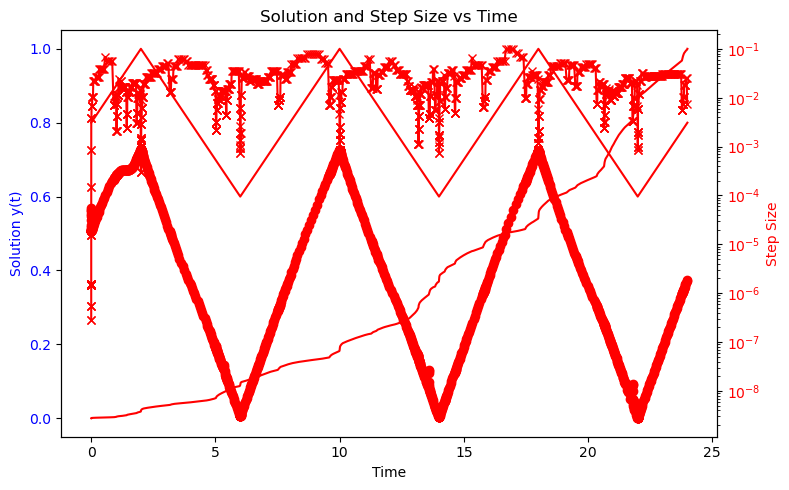

cool the cycle is OK!


In [50]:
color1="r"

steps=np.cumsum(range(len(sol0.t)))
steps=steps/steps[-1]

fig, ax1 = plt.subplots(figsize=(8, 5))

#sol0.t

res_volt=np.copy(sol0.t)
for i,j in enumerate(sol0.t):
    res_volt[i]=FCstate[2](j)

# Plot the solution y(t)
ax1.plot(sol0.t,res_volt,color=color1, label="voltage")
ax1.plot(sol0.t,steps,color=color1, label="steps")

ax1.set_xlabel("Time")
ax1.set_ylabel("Solution y(t)", color="b")
ax1.tick_params(axis="y", labelcolor="b")

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(sol0.t[:-1], step_sizes, 'r-', marker='x', label="Step Size")
ax2.set_ylabel("Step Size", color="r")
ax2.tick_params(axis="y", labelcolor="r")
ax2.set_yscale('log')

ax2.plot(sol0.t[:-1], abs(np.array(dxrt)), 'r-', marker='o', label="dx")

# Titles and legends
plt.title("Solution and Step Size vs Time")
fig.tight_layout()
plt.show()

#f_plot(sol0)
print("cool the cycle is OK!")

41
41
[9.94035785e+03 9.94035785e+05 1.29224652e+08 4.48310139e+08
 8.20079523e+08 1.12922465e+09 7.10735586e+08 4.66202783e+08
 1.74950298e+08 7.65407555e+07 2.08747515e+07 1.09343936e+07
 5.96421471e+06 9.94035785e+03 9.94035785e+05 9.94035785e+05
 1.98807157e+06 9.94035785e+03 9.94035785e+03 9.94035785e+05
 9.94035785e+03 9.94035785e+03 9.94035785e+03 9.94035785e+03
 9.94035785e+05 9.94035785e+03 9.94035785e+03 9.94035785e+03
 9.94035785e+03 9.94035785e+03 9.94035785e+03 9.94035785e+03
 9.94035785e+03 9.94035785e+03 9.94035785e+03 9.94035785e+03
 9.94035785e+03 9.94035785e+03 9.94035785e+03 9.94035785e+03
 9.94035785e+03]


(1000.0, 4000000000.0)

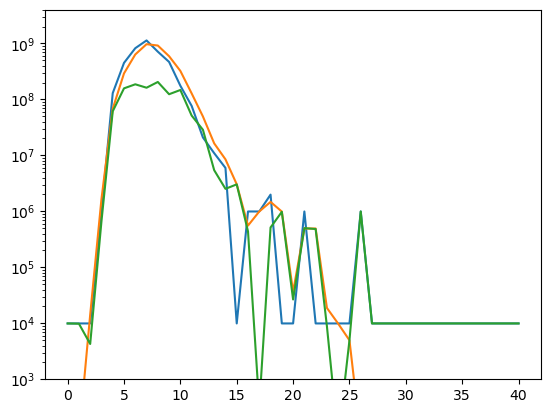

In [16]:
# v resnici premaknem po filingu dol na roko.
#yracunam in poogledam, kako velike so razlike
#effectively cin determines the size of the system

#ker gre input cez funkcijo, ki vrne normiran rezultat, je skala nepomembna?

NC=20
nmove=2
hist_fix
#no need to append since we will be cutting it anyways
#but keep the length due to existing code.
hist_moved=np.pad(hist_fix[nmove:], pad_width=(0,nmove), mode='constant', constant_values=hist_fix[-1])

print(len(hist_fix))

print(len(hist_moved))
print(hist_moved)

dist_bins_om ,vec_c, vec_l = bimet_morelife_gen3c.f_start_dist_cin(hist_moved,lmin1=0.25,lmax1=5.,cmin1=0.25, MPars=ModPars, loc_l=vek_in[0], scale_l=0.25*0.5)
pars=(ModPars0,vec_c,vec_l,FCstate[1],FCstate[2],FCstate[0])

#dist_bins_om = np.zeros((np.shape(dist_bins_om)))
#dist_bins_om[5,10]=1e30

r=bimet_morelife_gen3c.f_om_to_r(dist_bins_om)
rez_norm_r = bimet_morelife_gen3c.f_norm_dist1d(vec_r,r)

plt.plot(hist_fix)
#plt.plot(hist_moved)
#plt.plot(r)
plt.plot(rez_norm_r)

plt.plot(np.abs(rez_norm_r-hist_fix))

plt.yscale("log")
plt.ylim([1e3,4e9])

#problem we know, diferences in parameters for r, but not for c! the bins corerspond to 
#solve, go step bz step and fix, but it y

In [ ]:
bounds=[(0.4,0.7),(0.01,2),(0.01,1),(0.1,3)]
vek_0=[5e-01,2.699e-01,2.000e-01,1.148e+00]
#vek_0=[ 6.575e-01 , 2.699e-01 , 1.003e-02 , 1.325e+00]
#rezultat = differential_evolution(f_price_direct, bounds=bounds,x0=vek_0,polish=True,popsize=100, maxiter=200, callback=f_callback, tol=0.0001, disp = True,updating="deferred",workers=-1)


In [ ]:
rezultat

In [ ]:
#check 
vek_in=[ 6.573e-01 , 2.698e-01 , 1.105e-02 , 1.324e+00]
print(f_price(vek_in))


In [ ]:
#na roke preveri razmerje pt cu:

#V=4pir3/3
def f_vol(r):
    V=4*np.pi*r**3/3.
    return V

c=2
l=0.6

def f_cor_shell(l,c):
    V_cor   = f_vol(c)
    V_shell = f_vol(c+l)-f_vol(c)
    return V_cor,V_shell

def f_pt_cu(V_cor,V_shell,n=3.,sig_al=1.,sig_pt=1.):
    Cu=(1./(n+1.))*V_cor*sig_al
    Pt=(n/(n+1.))*V_cor*sig_al
    Pt=Pt+V_shell*sig_pt
    return Pt,Cu

V_cor,V_shell=f_cor_shell(l,c)
Pt,Cu=f_pt_cu(V_cor,V_shell)

print(V_cor,V_shell)
print(Pt/Cu)

#conclusion: assuming we have a sharp population of particles around 2nm in core radius we need incredibly 

In [ ]:
#interpolate to r values
fig=plt.figure(figsize=(14, 8))
ax11 = fig.add_subplot(1,1,1)
ax=ax11
im = ax.imshow(om,extent =[vec_c[0], vec_c[-1], vec_l[0], vec_l[-1]], interpolation ='none',origin='lower')
#im = ax.imshow(om,extent =[vec_c[0], vec_c[-1], vec_l[0], vec_l[-1]], interpolation ='none',origin='lower',norm=LogNorm(vmin=1e26, vmax=1e30))
fig.colorbar(im, ax=ax)
ax.set_title("doist BOE")



In [ ]:
rezultat

In [ ]:
#easily calculate pt/cu ratio.